In [1]:
import numpy as np
import pandas as pd
import sklearn

from scipy import stats
import scipy.stats as st
import scipy.special as sp
from scipy.stats import wilcoxon
from scipy.stats import norm
from scipy.stats import chi2_contingency
from scipy.stats import f
import matplotlib.pyplot as plt

%matplotlib inline

import copy
from utils.datalib_database import df_from_sql
import altair as alt
import datetime as dt
from datetime import date
import openpyxl

import seaborn as sns

sns.set(color_codes=True)
pd.set_option("display.max_columns", None)

import statsmodels.api as sm
from statsmodels.formula.api import ols
from bioinfokit.analys import stat

import warnings

warnings.filterwarnings("ignore")
plt.style.use("ggplot")

import itertools

warnings.filterwarnings("ignore")

## 1 Experiment Design

### 1.1 Targeting Groups

- Group 1: FTMAUs since 2021 CW10 with no Spaces + MAUs with no spaces
- Group 2: Current MAUs with spaces, no Roundups

The notifications will be focused on 'Goal', 'Save', and 'Spaces'/'Fun', treatment users in each targeting group will randomly receive one of the notifications. More content details please refer to the google slide writeup. Notifications' differentiation:
- Group 1: the goal is to educate newer-to-N26 and less-entrenched users about Spaces alongside the new, automated Round-up feature that makes saving money simple and easy
- Group 2: the goal is to introduce Spaces users the enhanced benefits of a feature they already know (and love!)

### 1.2 Define Metrics 

- Activated Round-Ups: total activation in 7 days, 14 days, and 35 days
- Transactions since receiving the notifications(made transactions or not, transaction counts, transaction amount)
- Transactions since enabled roundup after receiving the notifications (in 35 days, made transactions or not, transaction counts, transaction amount)
- Multiplier Applied: distribution and average

### 1.3 Traffic Segmentation

Traffic for each target audience group is randomly divided into three treatment groups(30%) and 1 control group(10%). 

## 2 Data Cleaning 

### 2.1 Import Data

Notes: 
For xlsx files, please download from this folder - 
https://drive.google.com/drive/folders/1QES7YyJaPVqIVBKyBiPDYyv0DPA3E417?usp=sharing

In [2]:
# import samples from group 1
group_1_treatment_a = pd.read_excel("1a.xlsx", "20210624_CRM_PUSH_RCT_roundup1_")
group_1_treatment_b = pd.read_excel("1b.xlsx", "20210624_CRM_PUSH_RCT_roundup1_")
group_1_treatment_c = pd.read_excel("1c.xlsx", "20210624_CRM_PUSH_RCT_roundup1_")
group_1_control = pd.read_excel("1control.xlsx", "20210624_CRM_PUSH_RCT_roundup1_")

In [3]:
# import samples from group 2
group_2_treatment_a = pd.read_excel("2a.xlsx", "20210624_CRM_PUSH_RCT_roundup1_")
group_2_treatment_b = pd.read_excel("2b.xlsx", "20210624_CRM_PUSH_RCT_roundup1_")
group_2_treatment_c = pd.read_excel("2c.xlsx", "20210624_CRM_PUSH_RCT_roundup1_")
group_2_control = pd.read_excel("2control.xlsx", "20210624_CRM_PUSH_RCT_roundup1_")

In [4]:
group_1_treatment_a.rename(columns={"UserID__pc": "user_id"}, inplace=True)
group_1_treatment_b.rename(columns={"UserID__pc": "user_id"}, inplace=True)
group_1_treatment_c.rename(columns={"UserID__pc": "user_id"}, inplace=True)
group_1_control.rename(columns={"UserID__pc": "user_id"}, inplace=True)
group_2_treatment_a.rename(columns={"UserID__pc": "user_id"}, inplace=True)
group_2_treatment_b.rename(columns={"UserID__pc": "user_id"}, inplace=True)
group_2_treatment_c.rename(columns={"UserID__pc": "user_id"}, inplace=True)
group_2_control.rename(columns={"UserID__pc": "user_id"}, inplace=True)

### 2.2 Sanity Check

In [5]:
# check basic info and duplicates
sep = "-" * 66
print("Duplicates Check:")
print("Group 1, treatment A", group_1_treatment_a.describe())
print(sep)
print("Group 1, treatment B", group_1_treatment_b.describe())
print(sep)
print("Group 1, treatment C", group_1_treatment_c.describe())
print(sep)
print("Group 1, control", group_1_control.describe())
print(sep)
print("Group 2, treatment A", group_2_treatment_a.describe())
print(sep)
print("Group 2, treatment B", group_2_treatment_b.describe())
print(sep)
print("Group 2, treatment C", group_2_treatment_c.describe())
print(sep)
print("Group 2, control", group_2_control.describe())

Duplicates Check:
Group 1, treatment A                                      user_id
count                                   2457
unique                                  2457
top     2f7b092a-c181-41f2-b16b-22a7be8e9944
freq                                       1
------------------------------------------------------------------
Group 1, treatment B                                      user_id
count                                   2457
unique                                  2457
top     477fa951-6a84-4d88-b53f-7b397307ed2a
freq                                       1
------------------------------------------------------------------
Group 1, treatment C                                      user_id
count                                   2457
unique                                  2457
top     f562124f-66fc-4b95-a00f-88a37873333d
freq                                       1
------------------------------------------------------------------
Group 1, control                           

In [6]:
# check null values
print("Duplicates Check:")
print("Group 1, treatment A", group_1_treatment_a.isnull().sum())
print(sep)
print("Group 1, treatment B", group_1_treatment_b.isnull().sum())
print(sep)
print("Group 1, treatment C", group_1_treatment_c.isnull().sum())
print(sep)
print("Group 1, control", group_1_control.isnull().sum())
print(sep)
print("Group 2, treatment A", group_2_treatment_a.isnull().sum())
print(sep)
print("Group 2, treatment B", group_2_treatment_b.isnull().sum())
print(sep)
print("Group 2, treatment C", group_2_treatment_c.isnull().sum())
print(sep)
print("Group 2, control", group_2_control.isnull().sum())

Duplicates Check:
Group 1, treatment A user_id    0
dtype: int64
------------------------------------------------------------------
Group 1, treatment B user_id    0
dtype: int64
------------------------------------------------------------------
Group 1, treatment C user_id    0
dtype: int64
------------------------------------------------------------------
Group 1, control user_id    0
dtype: int64
------------------------------------------------------------------
Group 2, treatment A user_id    0
dtype: int64
------------------------------------------------------------------
Group 2, treatment B user_id    0
dtype: int64
------------------------------------------------------------------
Group 2, treatment C user_id    0
dtype: int64
------------------------------------------------------------------
Group 2, control user_id    0
dtype: int64


## 3 Results and Analysis 

### 3.1 Sample Sizes 

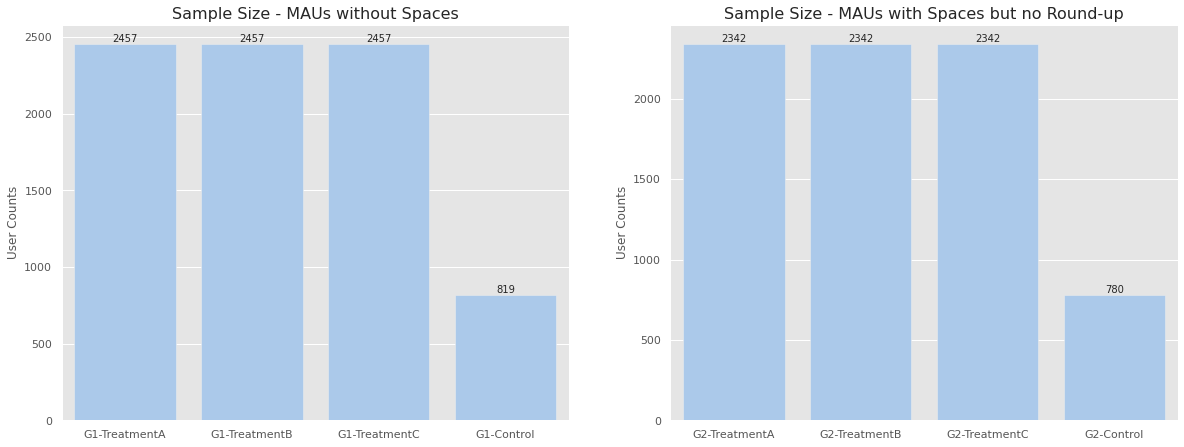

In [7]:
f = plt.subplots(figsize=(20, 16))

ax1 = plt.subplot(2, 2, 1)
sns.set_color_codes("pastel")
sns.barplot(
    x=["G1-TreatmentA", "G1-TreatmentB", "G1-TreatmentC", "G1-Control"],
    y=[
        group_1_treatment_a["user_id"].agg("count"),
        group_1_treatment_b["user_id"].agg("count"),
        group_1_treatment_c["user_id"].agg("count"),
        group_1_control["user_id"].agg("count"),
    ],
    ax=ax1,
    color="b",  # = "light:#5A9",
)
ax1.bar_label(ax1.containers[0])
ax1.set_title("Sample Size - MAUs without Spaces", fontsize=16)
plt.ylabel("User Counts")

ax2 = plt.subplot(2, 2, 2)
sns.set_color_codes("pastel")
sns.barplot(
    x=["G2-TreatmentA", "G2-TreatmentB", "G2-TreatmentC", "G2-Control"],
    y=[
        group_2_treatment_a["user_id"].agg("count"),
        group_2_treatment_b["user_id"].agg("count"),
        group_2_treatment_c["user_id"].agg("count"),
        group_2_control["user_id"].agg("count"),
    ],
    ax=ax2,
    color="b",  # = "light:#5A9",
)
ax2.bar_label(ax2.containers[0])
ax2.set_title("Sample Size - MAUs with Spaces but no Round-up", fontsize=16)
plt.ylabel("User Counts")

plt.show()

In [8]:
# mark the treatment groups for following usage
group_1_treatment_a["groups"] = "group_1_treatment_a"
group_1_treatment_b["groups"] = "group_1_treatment_b"
group_1_treatment_c["groups"] = "group_1_treatment_c"
group_1_control["groups"] = "group_1_control"
group_2_treatment_a["groups"] = "group_2_treatment_a"
group_2_treatment_b["groups"] = "group_2_treatment_b"
group_2_treatment_c["groups"] = "group_2_treatment_c"
group_2_control["groups"] = "group_2_control"

### 3.2 Activation

### 3.2.1 Activation Overview

In [9]:
# import more data
# import users activate the round_up
rp_enabled = """
select
    date(created) date,
    user_id,
    action_type,
    status
from
    etl_reporting.cn_automated_rule
where
    action_type = 'ROUND_UP' and 
    status = 'ENABLED' and
    date(updated) <= '2021-07-31'
"""
rp_enabled = df_from_sql("redshiftreader", rp_enabled)

{"message": "started", "db": "redshiftreader", "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 126, "funcName": "df_from_sql", "created": "20210924T044603", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "d68a1247-43bb-40d3-b6d8-05993c8a3abf", "hostname": "172.18.0.4"}
{"message": "success", "db": "redshiftreader", "duration": 0.8019, "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 136, "funcName": "df_from_sql", "created": "20210924T044604", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "d68a1247-43bb-40d3-b6d8-05993c8a3abf", "hostname": "172.18.0.4"}


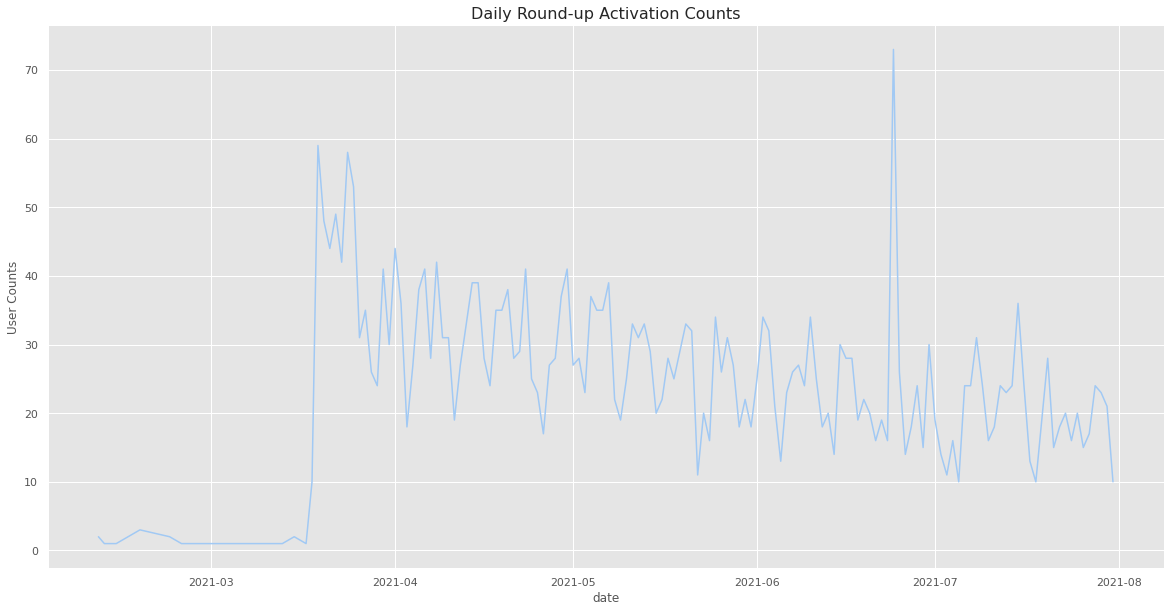

In [10]:
f, ax = plt.subplots(figsize=(20, 10))
sns.set_color_codes("pastel")
rp_enabled.groupby(["date"]).agg({"user_id": "count"}).plot(
    kind="line", legend=False, ax=ax, color="b"
)
ax.set_title("Daily Round-up Activation Counts", fontsize=16)
plt.ylabel("User Counts")
plt.show()

This chart shows the overall trend of round-up activation, a increase on the day we sent out the notification, however, after that day, the activation is back to normal level.

### 3.2.2 Group 1 and Group 2, which one has better activation rate after receiving the notification?

In [11]:
rp_enabled["date"] = pd.to_datetime(rp_enabled["date"])

In [12]:
rp_enabled = rp_enabled[rp_enabled.date >= "2021-06-24"]

In [13]:
rp_enabled_7d = rp_enabled[rp_enabled.date <= "2021-07-01"]
rp_enabled_14d = rp_enabled[rp_enabled.date <= "2021-07-08"]
rp_enabled_35d = rp_enabled[rp_enabled.date <= "2021-07-29"]

In [14]:
# merge all dates data
rp_group_1_treatment_a = pd.merge(
    left=group_1_treatment_a, right=rp_enabled, how="left", on=["user_id"]
)
rp_group_1_treatment_b = pd.merge(
    left=group_1_treatment_b, right=rp_enabled, how="left", on=["user_id"]
)
rp_group_1_treatment_c = pd.merge(
    left=group_1_treatment_c, right=rp_enabled, how="left", on=["user_id"]
)
rp_group_1_control = pd.merge(
    left=group_1_control, right=rp_enabled, how="left", on=["user_id"]
)
rp_group_2_treatment_a = pd.merge(
    left=group_2_treatment_a, right=rp_enabled, how="left", on=["user_id"]
)
rp_group_2_treatment_b = pd.merge(
    left=group_2_treatment_b, right=rp_enabled, how="left", on=["user_id"]
)
rp_group_2_treatment_c = pd.merge(
    left=group_2_treatment_c, right=rp_enabled, how="left", on=["user_id"]
)
rp_group_2_control = pd.merge(
    left=group_2_control, right=rp_enabled, how="left", on=["user_id"]
)

In [15]:
# combine the treatment and control groups together with all dates
rp_group_1 = pd.concat(
    [
        rp_group_1_treatment_a,
        rp_group_1_treatment_b,
        rp_group_1_treatment_c,
        rp_group_1_control,
    ]
)
rp_group_2 = pd.concat(
    [
        rp_group_2_treatment_a,
        rp_group_2_treatment_b,
        rp_group_2_treatment_c,
        rp_group_2_control,
    ]
)
# have a complete dateframe in case I need it in the following analysis

#### 3.2.2.1 Activation in 7 Days

In [16]:
# 7 days window, merge seperately so I can use it later when doing detailed treatment and control analysis
rp_group_1_treatment_a_7d = pd.merge(
    left=group_1_treatment_a, right=rp_enabled_7d, how="left", on=["user_id"]
)
rp_group_1_treatment_b_7d = pd.merge(
    left=group_1_treatment_b, right=rp_enabled_7d, how="left", on=["user_id"]
)
rp_group_1_treatment_c_7d = pd.merge(
    left=group_1_treatment_c, right=rp_enabled_7d, how="left", on=["user_id"]
)
rp_group_1_control_7d = pd.merge(
    left=group_1_control, right=rp_enabled_7d, how="left", on=["user_id"]
)
rp_group_2_treatment_a_7d = pd.merge(
    left=group_2_treatment_a, right=rp_enabled_7d, how="left", on=["user_id"]
)
rp_group_2_treatment_b_7d = pd.merge(
    left=group_2_treatment_b, right=rp_enabled_7d, how="left", on=["user_id"]
)
rp_group_2_treatment_c_7d = pd.merge(
    left=group_2_treatment_c, right=rp_enabled_7d, how="left", on=["user_id"]
)
rp_group_2_control_7d = pd.merge(
    left=group_2_control, right=rp_enabled_7d, how="left", on=["user_id"]
)

In [17]:
# combine the treatment and control groups together in 7 days
rp_group_1_7d = pd.concat(
    [
        rp_group_1_treatment_a_7d,
        rp_group_1_treatment_b_7d,
        rp_group_1_treatment_c_7d,
        rp_group_1_control_7d,
    ]
)
rp_group_2_7d = pd.concat(
    [
        rp_group_2_treatment_a_7d,
        rp_group_2_treatment_b_7d,
        rp_group_2_treatment_c_7d,
        rp_group_2_control_7d,
    ]
)

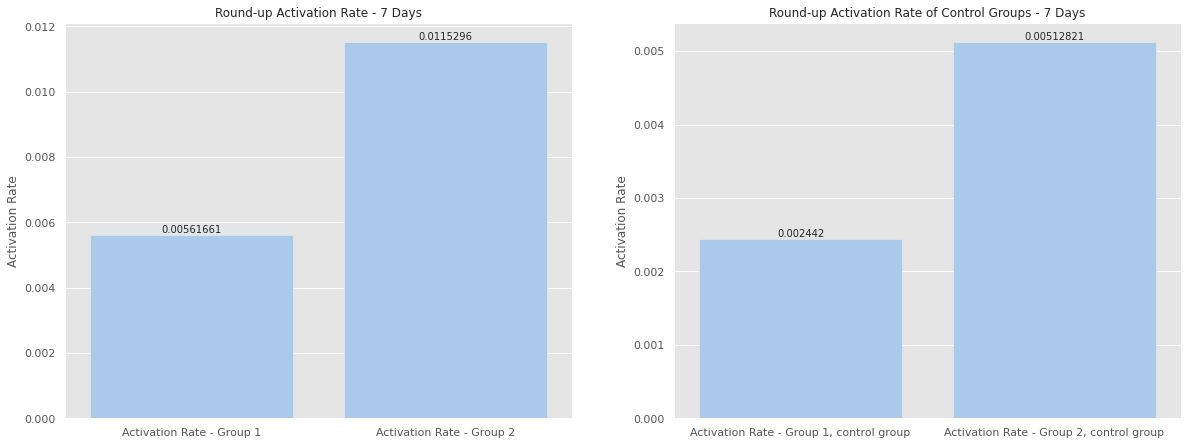

In [18]:
f = plt.subplots(figsize=(20, 16))

ax1 = plt.subplot(2, 2, 1)
sns.set_color_codes("pastel")
sns.barplot(
    x=["Activation Rate - Group 1", "Activation Rate - Group 2"],
    y=[
        rp_group_1_7d["status"].agg("count") / rp_group_1_7d["user_id"].agg("count"),
        rp_group_2_7d["status"].agg("count") / rp_group_2_7d["user_id"].agg("count"),
    ],
    ax=ax1,
    color="b",  # = "light:#5A9",
)
ax1.set_title("Round-up Activation Rate - 7 Days", fontsize=12)
ax1.bar_label(ax1.containers[0])
plt.ylabel("Activation Rate")


ax2 = plt.subplot(2, 2, 2)
sns.set_color_codes("pastel")
sns.barplot(
    x=[
        "Activation Rate - Group 1, control group",
        "Activation Rate - Group 2, control group",
    ],
    y=[
        rp_group_1_control_7d["status"].agg("count")
        / rp_group_1_control_7d["user_id"].agg("count"),
        rp_group_2_control_7d["status"].agg("count")
        / rp_group_2_control_7d["user_id"].agg("count"),
    ],
    ax=ax2,
    color="b",  # = "light:#5A9",
)
ax2.set_title("Round-up Activation Rate of Control Groups - 7 Days", fontsize=12)
plt.ylabel("Activation Rate")
ax2.bar_label(ax2.containers[0])
plt.show()

To compare the proportion of two populations, two sample z-test would be a choice for a hypothesis test. 
Assumptions:
- The null hypothesis (H0) for the test is that the proportions(activation rate) are the same. 
- The alternate hypothesis (H1) is that the proportions(activation rate) are not the same.

In [19]:
# calculate the zscore for 2 population proportions
n1 = rp_group_1.user_id.count()
n2 = rp_group_2.user_id.count()
p1 = rp_group_1_7d.status.count() / n1
p2 = rp_group_2_7d.status.count() / n2
p = np.mean([p1, p2])
z = ((p1 - p2) - 0) / np.sqrt(p * (1 - p) * (1 / n1 + 1 / n2))

In [20]:
# calculate the p_value
p_values = st.norm.sf(abs(z))

In [21]:
# return the result with a significance level of 0.01
if p_values > 0.01:
    print(
        "P value equals",
        p_values,
        ", fail to reject the null hypothesis, there are no significant differences between these two groups",
    )
else:
    print(
        "P value equals",
        p_values,
        ", reject the null hypothesis, there are significant differences between these two groups",
    )

P value equals 2.5099891704055438e-05 , reject the null hypothesis, there are significant differences between these two groups


Since there are differences between the two groups, I would like to conduct another hypothesis to test the users from these two groups but did not receive any notifications, so we can see if those two groups are originally different.

In [22]:
# calculate the zscore for 2 population proportions, for users who did not receive notifications
control_n1 = rp_group_1_control.user_id.count()
control_n2 = rp_group_2_control.user_id.count()
p1 = rp_group_1_control_7d.status.count() / control_n1
p2 = rp_group_2_control_7d.status.count() / control_n2
p = np.mean([p1, p2])
z = ((p1 - p2) - 0) / np.sqrt(p * (1 - p) * (1 / control_n1 + 1 / control_n2))

In [23]:
# calculate the p_value
p_values = st.norm.sf(abs(z))

In [24]:
# return the result with a significance level of 0.01
if p_values > 0.01:
    print(
        "P value equals",
        p_values,
        ", fail to reject the null hypothesis, there are no significant differences between these two groups",
    )
else:
    print(
        "P value equals",
        p_values,
        ", reject the null hypothesis, there are significant differences between these two groups",
    )

P value equals 0.19096215461344213 , fail to reject the null hypothesis, there are no significant differences between these two groups


#### 3.2.2.2 Activation in 14 Days

In [25]:
# 14 days window, seperately so I can use it later when doing detailed treatment and control analysis
rp_group_1_treatment_a_14d = pd.merge(
    left=group_1_treatment_a, right=rp_enabled_14d, how="left", on=["user_id"]
)
rp_group_1_treatment_b_14d = pd.merge(
    left=group_1_treatment_b, right=rp_enabled_14d, how="left", on=["user_id"]
)
rp_group_1_treatment_c_14d = pd.merge(
    left=group_1_treatment_c, right=rp_enabled_14d, how="left", on=["user_id"]
)
rp_group_1_control_14d = pd.merge(
    left=group_1_control, right=rp_enabled_14d, how="left", on=["user_id"]
)
rp_group_2_treatment_a_14d = pd.merge(
    left=group_2_treatment_a, right=rp_enabled_14d, how="left", on=["user_id"]
)
rp_group_2_treatment_b_14d = pd.merge(
    left=group_2_treatment_b, right=rp_enabled_14d, how="left", on=["user_id"]
)
rp_group_2_treatment_c_14d = pd.merge(
    left=group_2_treatment_c, right=rp_enabled_14d, how="left", on=["user_id"]
)
rp_group_2_control_14d = pd.merge(
    left=group_2_control, right=rp_enabled_14d, how="left", on=["user_id"]
)

In [26]:
# combine the treatment and control groups together in 14 days
rp_group_1_14d = pd.concat(
    [
        rp_group_1_treatment_a_14d,
        rp_group_1_treatment_b_14d,
        rp_group_1_treatment_c_14d,
        rp_group_1_control_14d,
    ]
)
rp_group_2_14d = pd.concat(
    [
        rp_group_2_treatment_a_14d,
        rp_group_2_treatment_b_14d,
        rp_group_2_treatment_c_14d,
        rp_group_2_control_14d,
    ]
)

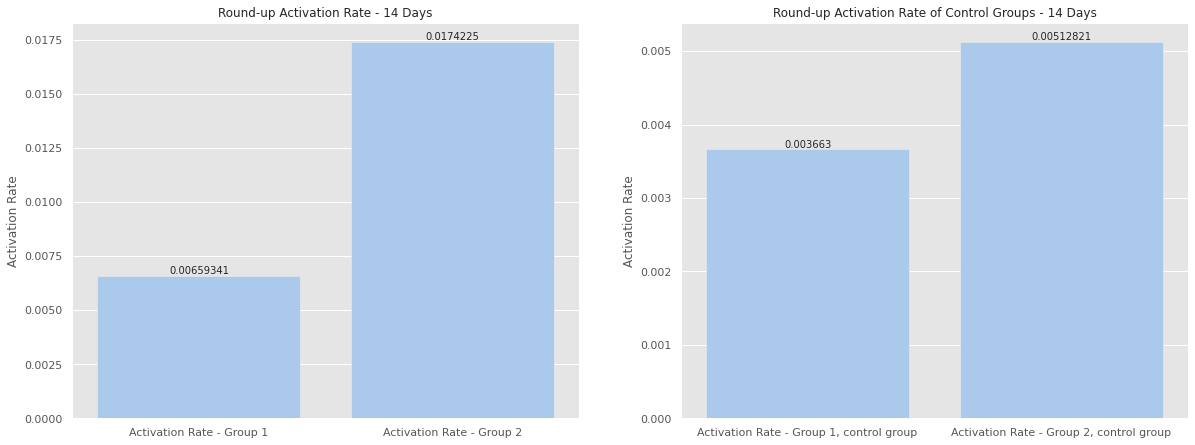

In [27]:
f = plt.subplots(figsize=(20, 16))

ax1 = plt.subplot(2, 2, 1)
sns.set_color_codes("pastel")
sns.barplot(
    x=["Activation Rate - Group 1", "Activation Rate - Group 2"],
    y=[
        rp_group_1_14d["status"].agg("count") / rp_group_1_14d["user_id"].agg("count"),
        rp_group_2_14d["status"].agg("count") / rp_group_2_14d["user_id"].agg("count"),
    ],
    ax=ax1,
    color="b",  # = "light:#5A9",
)
ax1.set_title("Round-up Activation Rate - 14 Days", fontsize=12)
ax1.bar_label(ax1.containers[0])
plt.ylabel("Activation Rate")


ax2 = plt.subplot(2, 2, 2)
sns.set_color_codes("pastel")
sns.barplot(
    x=[
        "Activation Rate - Group 1, control group",
        "Activation Rate - Group 2, control group",
    ],
    y=[
        rp_group_1_control_14d["status"].agg("count")
        / rp_group_1_control_14d["user_id"].agg("count"),
        rp_group_2_control_14d["status"].agg("count")
        / rp_group_2_control_14d["user_id"].agg("count"),
    ],
    ax=ax2,
    color="b",  # = "light:#5A9",
)
ax2.set_title("Round-up Activation Rate of Control Groups - 14 Days", fontsize=12)
plt.ylabel("Activation Rate")
ax2.bar_label(ax2.containers[0])
plt.show()

From the chart, the Conversion Rate of Group 2 is still higher than group 1, here is hypothesis test to prove it:
- The null hypothesis (H0) for the test is that the proportions(activation rate) are the same.
- The alternate hypothesis (H1) is that the proportions(activation rate) are not the same.

In [28]:
# calculate the zscore for 2 population proportions
p1 = rp_group_1_14d.status.count() / n1
p2 = rp_group_2_14d.status.count() / n2
p = np.mean([p1, p2])
z = ((p1 - p2) - 0) / np.sqrt(p * (1 - p) * (1 / n1 + 1 / n2))

In [29]:
# calculate the p_value
p_values = st.norm.sf(abs(z))

In [30]:
# return the result with a significance level of 0.01
if p_values > 0.01:
    print(
        "P value equals",
        p_values,
        ", fail to reject the null hypothesis, there are no significant difference between these two groups",
    )
else:
    print(
        "P value equals",
        p_values,
        ", reject the null hypothesis, there is significant difference between these two groups",
    )

P value equals 1.6353049879326806e-10 , reject the null hypothesis, there is significant difference between these two groups


In [31]:
# calculate the zscore for 2 population proportions, for users who did not receive notifications
p1 = rp_group_1_control_14d.status.count() / control_n1
p2 = rp_group_2_control_14d.status.count() / control_n2
p = np.mean([p1, p2])
z = ((p1 - p2) - 0) / np.sqrt(p * (1 - p) * (1 / control_n1 + 1 / control_n2))

In [32]:
# calculate the p_value
p_values = st.norm.sf(abs(z))

In [33]:
# return the result with a significance level of 0.01
if p_values > 0.01:
    print(
        "P value equals",
        p_values,
        ", fail to reject the null hypothesis, there are no significant differences between these two groups",
    )
else:
    print(
        "P value equals",
        p_values,
        ", reject the null hypothesis, there are significant differences between these two groups",
    )

P value equals 0.32899131943165605 , fail to reject the null hypothesis, there are no significant differences between these two groups


#### 3.2.2.2 Activation in 35 Days

In [34]:
# 35 days window, seperately so we can use it later when doing detailed treatment and control analysis
rp_group_1_treatment_a_35d = pd.merge(
    left=group_1_treatment_a, right=rp_enabled_35d, how="left", on=["user_id"]
)
rp_group_1_treatment_b_35d = pd.merge(
    left=group_1_treatment_b, right=rp_enabled_35d, how="left", on=["user_id"]
)
rp_group_1_treatment_c_35d = pd.merge(
    left=group_1_treatment_c, right=rp_enabled_35d, how="left", on=["user_id"]
)
rp_group_1_control_35d = pd.merge(
    left=group_1_control, right=rp_enabled_35d, how="left", on=["user_id"]
)
rp_group_2_treatment_a_35d = pd.merge(
    left=group_2_treatment_a, right=rp_enabled_35d, how="left", on=["user_id"]
)
rp_group_2_treatment_b_35d = pd.merge(
    left=group_2_treatment_b, right=rp_enabled_35d, how="left", on=["user_id"]
)
rp_group_2_treatment_c_35d = pd.merge(
    left=group_2_treatment_c, right=rp_enabled_35d, how="left", on=["user_id"]
)
rp_group_2_control_35d = pd.merge(
    left=group_2_control, right=rp_enabled_35d, how="left", on=["user_id"]
)

In [35]:
# combine the treatment and control groups together in 35 days
rp_group_1_35d = pd.concat(
    [
        rp_group_1_treatment_a_35d,
        rp_group_1_treatment_b_35d,
        rp_group_1_treatment_c_35d,
        rp_group_1_control_35d,
    ]
)
rp_group_2_35d = pd.concat(
    [
        rp_group_2_treatment_a_35d,
        rp_group_2_treatment_b_35d,
        rp_group_2_treatment_c_35d,
        rp_group_2_control_35d,
    ]
)

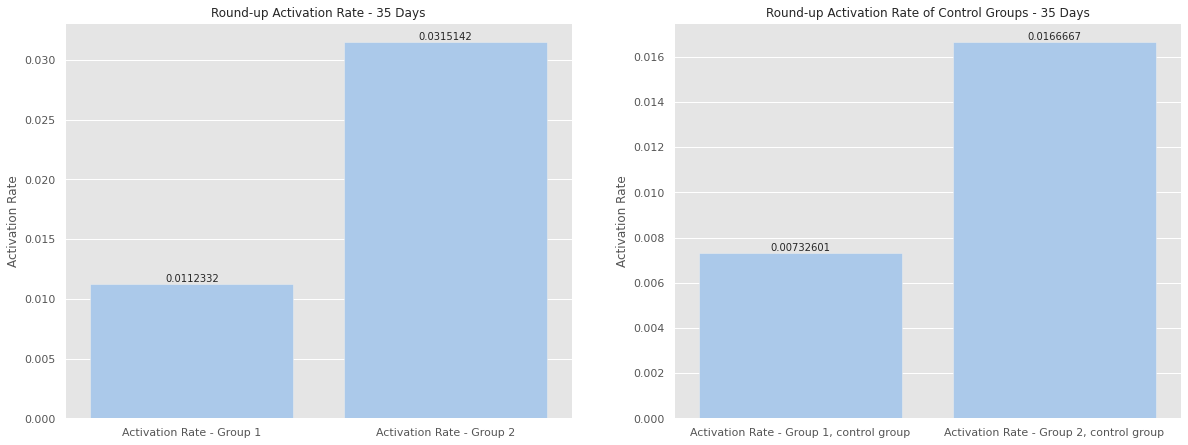

In [36]:
f = plt.subplots(figsize=(20, 16))

ax1 = plt.subplot(2, 2, 1)
sns.set_color_codes("pastel")
sns.barplot(
    x=["Activation Rate - Group 1", "Activation Rate - Group 2"],
    y=[
        rp_group_1_35d["status"].agg("count") / rp_group_1_35d["user_id"].agg("count"),
        rp_group_2_35d["status"].agg("count") / rp_group_2_35d["user_id"].agg("count"),
    ],
    ax=ax1,
    color="b",  # = "light:#5A9",
)
ax1.set_title("Round-up Activation Rate - 35 Days", fontsize=12)
ax1.bar_label(ax1.containers[0])
plt.ylabel("Activation Rate")


ax2 = plt.subplot(2, 2, 2)
sns.set_color_codes("pastel")
sns.barplot(
    x=[
        "Activation Rate - Group 1, control group",
        "Activation Rate - Group 2, control group",
    ],
    y=[
        rp_group_1_control_35d["status"].agg("count")
        / rp_group_1_control_35d["user_id"].agg("count"),
        rp_group_2_control_35d["status"].agg("count")
        / rp_group_2_control_35d["user_id"].agg("count"),
    ],
    ax=ax2,
    color="b",  # = "light:#5A9",
)
ax2.set_title("Round-up Activation Rate of Control Groups - 35 Days", fontsize=12)
plt.ylabel("Activation Rate")
ax2.bar_label(ax2.containers[0])
plt.show()

In a period of 35 days, Group 2 is still the winner of the activation rate, here is hypothesis test:
- The null hypothesis (H0) for the test is that the proportions(activation rate) are the same.
- The alternate hypothesis (H1) is that the proportions(activation rate) are not the same.

In [37]:
##calculate the zscore for 2 population proportions
p1 = rp_group_1_35d.status.count() / n1
p2 = rp_group_2_35d.status.count() / n2
p = np.mean([p1, p2])
z = ((p1 - p2) - 0) / np.sqrt(p * (1 - p) * (1 / n1 + 1 / n2))

In [38]:
# calculate the p_value
p_values = st.norm.sf(abs(z))

In [39]:
# return the result with a significance level of 0.01
if p_values > 0.01:
    print(
        "P value equals",
        p_values,
        ", fail to reject the null hypothesis, there are no significant differences between these two groups",
    )
else:
    print(
        "P value equals",
        p_values,
        ", reject the null hypothesis, there is significant difference between these two groups",
    )

P value equals 3.816184067324938e-19 , reject the null hypothesis, there is significant difference between these two groups


In [40]:
# calculate the zscore for 2 population proportions, for users who did not receive notifications
p1 = rp_group_1_control_35d.status.count() / control_n1
p2 = rp_group_2_control_35d.status.count() / control_n2
p = np.mean([p1, p2])
z = ((p1 - p2) - 0) / np.sqrt(p * (1 - p) * (1 / control_n1 + 1 / control_n2))

In [41]:
# calculate the p_value
p_values = st.norm.sf(abs(z))

In [42]:
# return the result with a significance level of 0.01
if p_values > 0.01:
    print(
        "P value equals",
        p_values,
        ", fail to reject the null hypothesis, there are no significant differences between these two groups",
    )
else:
    print(
        "P value equals",
        p_values,
        ", reject the null hypothesis, there are significant differences between these two groups",
    )

P value equals 0.04318172797202958 , fail to reject the null hypothesis, there are no significant differences between these two groups


In 7, 14, 35 days, the control groups in the two groups activation rate are not significantly different from each other, but the overall activation rate for two groups are different. Therefore, we can interpret that the notifications are more effective for group 2 - MAUs who have spaces.

#### 3.2.2.4 Activation Trend

In [43]:
g1 = rp_group_1.groupby(["date"]).agg("count")["status"]
g2 = rp_group_2.groupby(["date"]).agg("count")["status"]

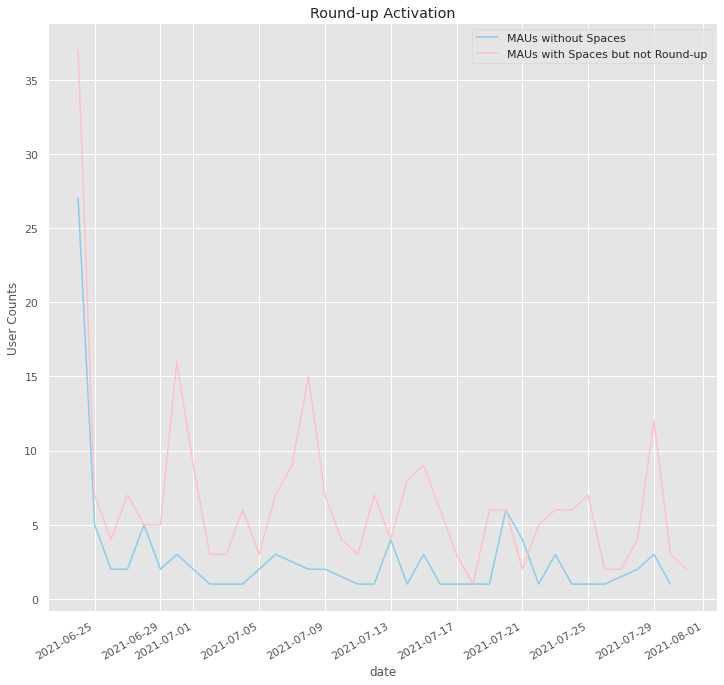

In [44]:
# plot the line chart to show the activation changes overtime
fig, ax = plt.subplots(figsize=(12, 12))
g1.plot(kind="line", label="MAUs without Spaces", color="skyblue", ax=ax)
g2.plot(kind="line", label="MAUs with Spaces but not Round-up", color="pink", ax=ax)
ax.set_title("Round-up Activation")
plt.ylabel("User Counts")
plt.legend(loc="best")
plt.show()

While the total activation of MAUs who have Spaces are statistically significantly higher than MAUs who do not have Spaces, the activation of MAUs who have Spaces are higher than the other group almost every day.

### 3.2.3 In Group 1, do users activate roundup after receiving the push notifications ?

#### 3.2.3.1 Activation in 7 Days 

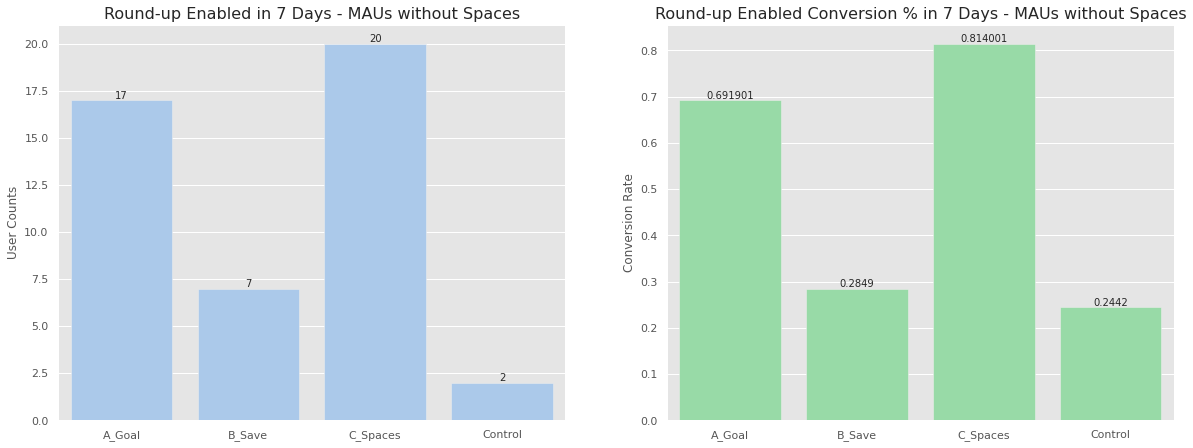

In [45]:
# plot the activation rate for each treatment groups and the control group
f = plt.subplots(figsize=(20, 16))
ax1 = plt.subplot(2, 2, 1)
sns.set_color_codes("pastel")
sns.barplot(
    x=["A_Goal", "B_Save", "C_Spaces", "Control"],
    y=[
        rp_group_1_treatment_a_7d["status"].agg("count"),
        rp_group_1_treatment_b_7d["status"].agg("count"),
        rp_group_1_treatment_c_7d["status"].agg("count"),
        rp_group_1_control_7d["status"].agg("count"),
    ],
    ax=ax1,
    color="b",  # = "light:#5A9",
)
ax1.bar_label(ax1.containers[0])
ax1.set_title("Round-up Enabled in 7 Days - MAUs without Spaces", fontsize=16)
plt.ylabel("User Counts")

ax2 = plt.subplot(2, 2, 2)
sns.set_color_codes("pastel")
sns.barplot(
    x=["A_Goal", "B_Save", "C_Spaces", "Control"],
    y=[
        100
        * rp_group_1_treatment_a_7d["status"].agg("count")
        / rp_group_1_treatment_a_7d["user_id"].agg("count"),
        100
        * rp_group_1_treatment_b_7d["status"].agg("count")
        / rp_group_1_treatment_b_7d["user_id"].agg("count"),
        100
        * rp_group_1_treatment_c_7d["status"].agg("count")
        / rp_group_1_treatment_c_7d["user_id"].agg("count"),
        100
        * rp_group_1_control_7d["status"].agg("count")
        / rp_group_1_control_7d["user_id"].agg("count"),
    ],
    ax=ax2,
    color="g",
)
ax2.bar_label(ax2.containers[0])
ax2.set_title(
    "Round-up Enabled Conversion % in 7 Days - MAUs without Spaces", fontsize=16
)
plt.ylabel("Conversion Rate")

plt.show()

Since there are more than two groups here, z-test method is no longer appropriate. A Chi-square test will be performed here to prove the significance of my assumptions.

Hypothesis Test: 
- Null hypothesis - in 7 days, there are no significant differences among the treatment groups and the control group
- Alternative hypothesis - in 7 days, there are significant differences among the treatment groups and the control group

In [46]:
# rename the activation status
rp_group_1_7d["status"] = rp_group_1_7d["status"].replace(np.NaN, 0)
rp_group_1_7d["status"] = rp_group_1_7d["status"].replace("ENABLED", 1)

In [47]:
# select sample info
group_1_status_7d = rp_group_1_7d["status"]
group_1_groups_7d = rp_group_1_7d["groups"]

In [48]:
# create the cross table
group_1_crosstab_7d = pd.crosstab(group_1_status_7d, group_1_groups_7d)

In [49]:
group_1_crosstab_7d

groups,group_1_control,group_1_treatment_a,group_1_treatment_b,group_1_treatment_c
status,,,,
0,817,2440,2450,2437
1,2,17,7,20


In [50]:
# calculate the row 1 col 1 chi square value, p value, df, and expected values
g1_7d_chiVal, g1_7d_pVal, g1_7d_df, g1_7d_exp = chi2_contingency(group_1_crosstab_7d)

In [188]:
print(
    "At a significance level of 0.05, the first value of chi-square value of",
    g1_7d_chiVal,
    ", the p-value is",
    g1_7d_pVal,
    ", the degree of freedom is",
    g1_7d_df,
    ", and the expected values are",
    g1_7d_exp.tolist(),
    ". \nTherefore, in 7 days window, ",
    end="",
)
if g1_7d_pVal > 0.05:
    print(
        "the P value is > 0.05, we fail to reject the null hypothesis at the significance level of 0.05, and there are no differences among the treatment groups and the control group."
    )

else:
    print(
        "the P value is < 0.05, we reject the null hypothesis, there are significant differences between these groups."
    )

At a significance level of 0.05, the first value of chi-square value of 8.394977363970272 , the p-value is 0.038516500505885884 , the degree of freedom is 3 , and the expected values are [[814.4, 2443.2, 2443.2, 2443.2], [4.6, 13.8, 13.8, 13.8]] . 
Therefore, in 7 days window, the P value is < 0.05, we reject the null hypothesis, there are significant differences between these groups.


Since the effectiveness of the treatment has been proved, now each treatment group should be compared to see which one performs the best.

In [52]:
def cramers_V(var1, var2):
    crosstab = np.array(
        pd.crosstab(var1, var2, rownames=None, colnames=None)
    )  # Cross table building
    stat = chi2_contingency(crosstab)[
        0
    ]  # Keeping of the test statistic of the Chi2 test
    obs = np.sum(crosstab)  # Number of observations
    mini = (
        min(crosstab.shape) - 1
    )  # Take the minimum value between the columns and the rows of the cross table
    return (stat / obs) / mini

In [53]:
# first chose your category columns of interest
df1 = rp_group_1_7d[["groups", "status"]]
# now change this to dummy variables, one-hot encoded:
DataMatrix1 = pd.get_dummies(df1)

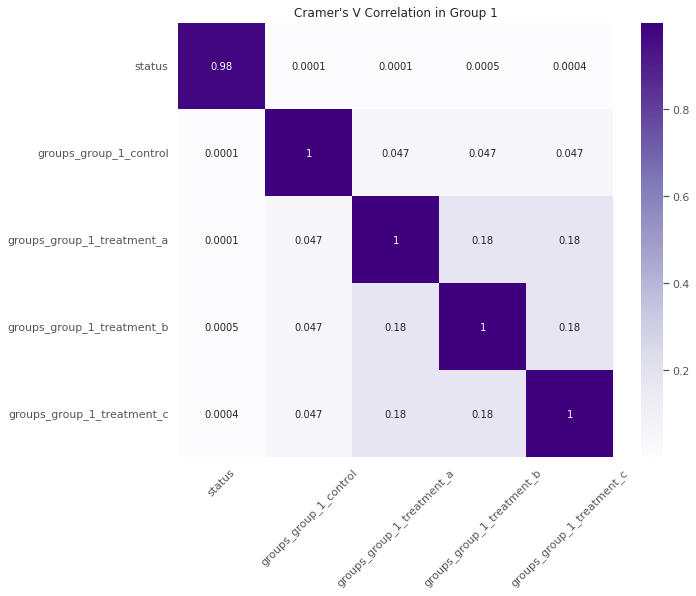

In [54]:
rows = []

for var1 in DataMatrix1:
    col = []
    for var2 in DataMatrix1:
        cramers = cramers_V(DataMatrix1[var1], DataMatrix1[var2])  # Cramer's V test
        col.append(round(cramers, 4))  # Keeping of the rounded value of the Cramer's V
    rows.append(col)

cramers_results = np.array(rows)
df1 = pd.DataFrame(
    cramers_results, columns=DataMatrix1.columns, index=DataMatrix1.columns
)

# mask = np.zeros_like(df, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(10, 8))

ax = sns.heatmap(df1, cmap="Purples", square=True, annot=True)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title("Cramer's V Correlation in Group 1", fontsize=12)


plt.show()

As the color shows in the heatmap, all the treatment groups have higher correlation with the activation status than the control group, but treatment C Spaces affected the activation the most.

#### 3.2.3.2 Activation in 14 Days 

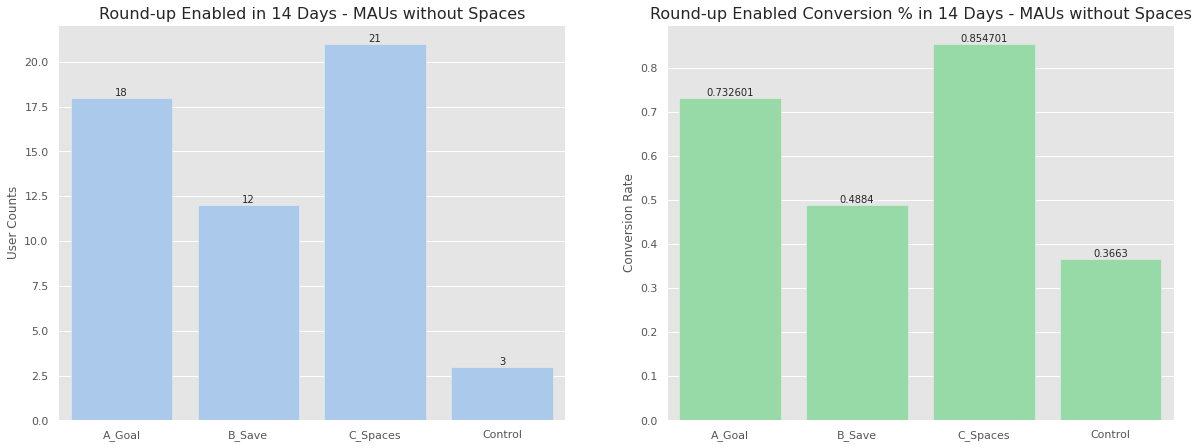

In [55]:
# plot the activation rate for each treatment groups and the control group
f = plt.subplots(figsize=(20, 16))
ax1 = plt.subplot(2, 2, 1)
sns.set_color_codes("pastel")
sns.barplot(
    x=["A_Goal", "B_Save", "C_Spaces", "Control"],
    y=[
        rp_group_1_treatment_a_14d["status"].agg("count"),
        rp_group_1_treatment_b_14d["status"].agg("count"),
        rp_group_1_treatment_c_14d["status"].agg("count"),
        rp_group_1_control_14d["status"].agg("count"),
    ],
    ax=ax1,
    color="b",  # = "light:#5A9",
)
ax1.bar_label(ax1.containers[0])
ax1.set_title("Round-up Enabled in 14 Days - MAUs without Spaces", fontsize=16)
plt.ylabel("User Counts")

ax2 = plt.subplot(2, 2, 2)
sns.set_color_codes("pastel")
sns.barplot(
    x=["A_Goal", "B_Save", "C_Spaces", "Control"],
    y=[
        100
        * rp_group_1_treatment_a_14d["status"].agg("count")
        / rp_group_1_treatment_a_14d["user_id"].agg("count"),
        100
        * rp_group_1_treatment_b_14d["status"].agg("count")
        / rp_group_1_treatment_b_14d["user_id"].agg("count"),
        100
        * rp_group_1_treatment_c_14d["status"].agg("count")
        / rp_group_1_treatment_c_14d["user_id"].agg("count"),
        100
        * rp_group_1_control_14d["status"].agg("count")
        / rp_group_1_control_14d["user_id"].agg("count"),
    ],
    ax=ax2,
    color="g",
)
ax2.bar_label(ax2.containers[0])
ax2.set_title(
    "Round-up Enabled Conversion % in 14 Days - MAUs without Spaces", fontsize=16
)
plt.ylabel("Conversion Rate")

plt.show()

Hypothesis Test: 
- Null hypothesis - in 14 days, there are no significant differences among the treatment groups and the control group
- Alternative hypothesis - in 14 days, there are significant differences among the treatment groups and the control group

In [56]:
# rename the activation status
rp_group_1_14d["status"] = rp_group_1_14d["status"].replace(np.NaN, 0)
rp_group_1_14d["status"] = rp_group_1_14d["status"].replace("ENABLED", 1)

In [57]:
# select sample info
group_1_status_14d = rp_group_1_14d["status"]
group_1_groups_14d = rp_group_1_14d["groups"]

In [58]:
# create the cross table
group_1_crosstab_14d = pd.crosstab(group_1_status_14d, group_1_groups_14d)

In [59]:
group_1_crosstab_14d

groups,group_1_control,group_1_treatment_a,group_1_treatment_b,group_1_treatment_c
status,,,,
0,816,2439,2445,2436
1,3,18,12,21


In [60]:
# calculate the row 1 col 1 chi square value, p value, df, and expected values
g1_14d_chiVal, g1_14d_pVal, g1_14d_df, g1_14d_exp = chi2_contingency(
    group_1_crosstab_14d
)

In [189]:
print(
    "At a significance level of 0.05, the first value of chi-square value of",
    g1_14d_chiVal,
    ", the p-value is",
    g1_14d_pVal,
    ", the degree of freedom is",
    g1_14d_df,
    ", and the expected values are",
    g1_14d_exp.tolist(),
    ". \nTherefore, in 14 days window, ",
    end="",
)
if g1_14d_pVal > 0.05:
    print(
        "since the P value is > 0.05, we fail to reject the null hypothesis at the significance level of 0.05, and there are no significant differences among the treatment groups and the control group."
    )

else:
    print(
        "since the P value is < 0.05, we reject the null hypothesis, there are significant differences between these groups"
    )

At a significance level of 0.05, the first value of chi-square value of 3.8028515240904626 , the p-value is 0.2835546248564951 , the degree of freedom is 3 , and the expected values are [[813.6, 2440.8, 2440.8, 2440.8], [5.4, 16.2, 16.2, 16.2]] . 
Therefore, in 14 days window, since the P value is > 0.05, we fail to reject the null hypothesis at the significance level of 0.05, and there are no significant differences among the treatment groups and the control group.


The differences are not significant 14 days after we sent out the notifications, so there will be even less effects after 30 days, but I am still conducting this test.

#### 3.2.3.2 Activation in 35 Days 

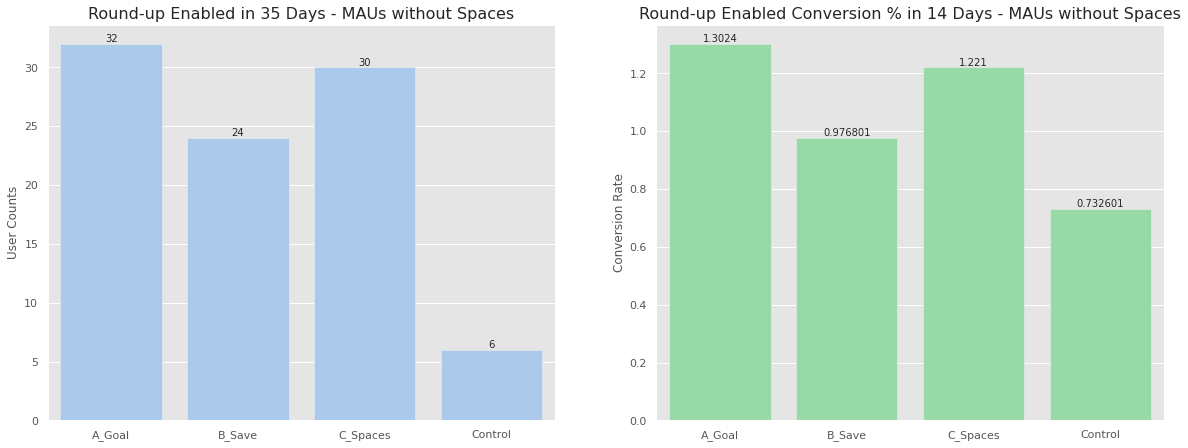

In [62]:
# plot the activation rate for each treatment groups and the control group
f = plt.subplots(figsize=(20, 16))
ax1 = plt.subplot(2, 2, 1)
sns.set_color_codes("pastel")
sns.barplot(
    x=["A_Goal", "B_Save", "C_Spaces", "Control"],
    y=[
        rp_group_1_treatment_a_35d["status"].agg("count"),
        rp_group_1_treatment_b_35d["status"].agg("count"),
        rp_group_1_treatment_c_35d["status"].agg("count"),
        rp_group_1_control_35d["status"].agg("count"),
    ],
    ax=ax1,
    color="b",  # = "light:#5A9",
)
ax1.bar_label(ax1.containers[0])
ax1.set_title("Round-up Enabled in 35 Days - MAUs without Spaces", fontsize=16)
plt.ylabel("User Counts")

ax2 = plt.subplot(2, 2, 2)
sns.set_color_codes("pastel")
sns.barplot(
    x=["A_Goal", "B_Save", "C_Spaces", "Control"],
    y=[
        100
        * rp_group_1_treatment_a_35d["status"].agg("count")
        / rp_group_1_treatment_a_35d["user_id"].agg("count"),
        100
        * rp_group_1_treatment_b_35d["status"].agg("count")
        / rp_group_1_treatment_b_35d["user_id"].agg("count"),
        100
        * rp_group_1_treatment_c_35d["status"].agg("count")
        / rp_group_1_treatment_c_35d["user_id"].agg("count"),
        100
        * rp_group_1_control_35d["status"].agg("count")
        / rp_group_1_control_35d["user_id"].agg("count"),
    ],
    ax=ax2,
    color="g",
)
ax2.bar_label(ax2.containers[0])
ax2.set_title(
    "Round-up Enabled Conversion % in 14 Days - MAUs without Spaces", fontsize=16
)
plt.ylabel("Conversion Rate")

plt.show()

Hypothesis Test: 
- Null hypothesis - in 35 days, there are no significant differences among the treatment groups and the control group
- Alternative hypothesis - in 35 days, there are significant differences among the treatment groups and the control group

In [63]:
# rename the activation status
rp_group_1_35d["status"] = rp_group_1_35d["status"].replace(np.NaN, "nonactivated")
rp_group_1_35d["status"] = rp_group_1_35d["status"].replace("ENABLED", "activated")

In [64]:
# select sample info
group_1_status_35d = rp_group_1_35d["status"]
group_1_groups_35d = rp_group_1_35d["groups"]

In [65]:
# create the cross table
group_1_crosstab_35d = pd.crosstab(group_1_status_35d, group_1_groups_35d)

In [66]:
group_1_crosstab_35d

groups,group_1_control,group_1_treatment_a,group_1_treatment_b,group_1_treatment_c
status,,,,
activated,6,32,24,30
nonactivated,813,2425,2433,2427


In [67]:
# calculate the row 1 col 1 chi square value, p value, df, and expected values
g1_35d_chiVal, g1_35d_pVal, g1_35d_df, g1_35d_exp = chi2_contingency(
    group_1_crosstab_35d
)

In [187]:
print(
    "At a significance level of 0.05, the first value of chi-square value of",
    g1_35d_chiVal,
    ", the p-value is",
    g1_35d_pVal,
    ", the degree of freedom is",
    g1_35d_df,
    ", and the expected values are",
    g1_14d_exp.tolist(),
    ". \nTherefore, in 35 days window, ",
    end="",
)
if g1_35d_pVal > 0.05:
    print(
        "since the P value is > 0.05, we fail to reject the null hypothesis at the significance level of 0.05, and there are no significant differences among the treatment groups and the control group."
    )
else:
    print(
        "since the P value is < 0.05, we reject the null hypothesis, there are significant differences between these groups"
    )

At a significance level of 0.05, the first value of chi-square value of 2.5210733729208497 , the p-value is 0.47149468845860454 , the degree of freedom is 3 , and the expected values are [[813.6, 2440.8, 2440.8, 2440.8], [5.4, 16.2, 16.2, 16.2]] . 
Therefore, in 35 days window, since the P value is > 0.05, we fail to reject the null hypothesis at the significance level of 0.05, and there are no significant differences among the treatment groups and the control group.


#### 3.2.3.4 Activation Trend

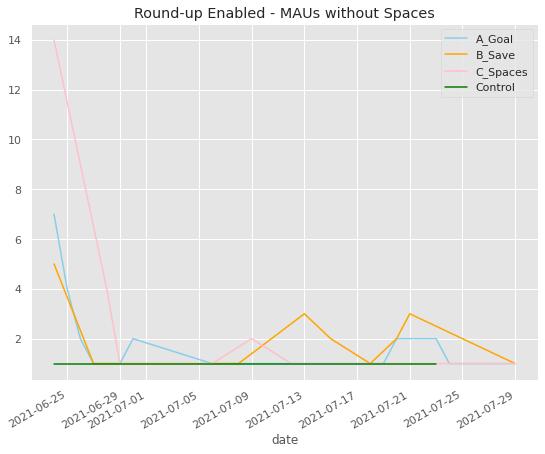

In [69]:
fig, ax = plt.subplots(figsize=(20, 16))

ax1 = plt.subplot(221)
rp_group_1_treatment_a_35d.groupby(["date"]).agg("count")["status"].plot(
    kind="line", label="A_Goal", color="skyblue", ax=ax1
)
rp_group_1_treatment_b_35d.groupby(["date"]).agg("count")["status"].plot(
    kind="line", label="B_Save", color="orange", ax=ax1
)
rp_group_1_treatment_c_35d.groupby(["date"]).agg("count")["status"].plot(
    kind="line", label="C_Spaces", color="pink", ax=ax1
)
rp_group_1_control_35d.groupby(["date"]).agg("count")["status"].plot(
    kind="line", label="Control", color="green", ax=ax1
)
ax1.set_title("Round-up Enabled - MAUs without Spaces")
plt.legend(loc="best")

plt.show()

### 3.2.4 In Group 2, do users activate roundup after receiving the push notifications ?

#### 3.2.4.1 Activation in 7 Days 

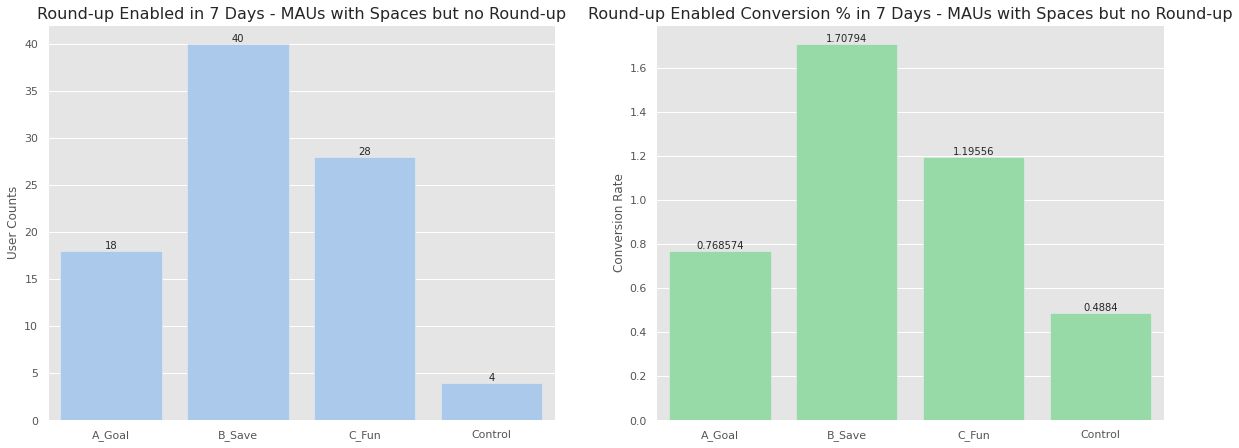

In [70]:
# plot the activation rate for each treatment groups and the control group
f = plt.subplots(figsize=(20, 16))
ax1 = plt.subplot(2, 2, 1)
sns.set_color_codes("pastel")
sns.barplot(
    x=["A_Goal", "B_Save", "C_Fun", "Control"],
    y=[
        rp_group_2_treatment_a_7d["status"].agg("count"),
        rp_group_2_treatment_b_7d["status"].agg("count"),
        rp_group_2_treatment_c_7d["status"].agg("count"),
        rp_group_2_control_7d["status"].agg("count"),
    ],
    ax=ax1,
    color="b",  # = "light:#5A9",
)
ax1.bar_label(ax1.containers[0])
ax1.set_title(
    "Round-up Enabled in 7 Days - MAUs with Spaces but no Round-up", fontsize=16
)
plt.ylabel("User Counts")

ax2 = plt.subplot(2, 2, 2)
sns.set_color_codes("pastel")
sns.barplot(
    x=["A_Goal", "B_Save", "C_Fun", "Control"],
    y=[
        100
        * rp_group_2_treatment_a_7d["status"].agg("count")
        / rp_group_2_treatment_a_7d["user_id"].agg("count"),
        100
        * rp_group_2_treatment_b_7d["status"].agg("count")
        / rp_group_2_treatment_b_7d["user_id"].agg("count"),
        100
        * rp_group_2_treatment_c_7d["status"].agg("count")
        / rp_group_2_treatment_c_7d["user_id"].agg("count"),
        100
        * rp_group_2_control_7d["status"].agg("count")
        / rp_group_1_control_7d["user_id"].agg("count"),
    ],
    ax=ax2,
    color="g",
)
ax2.bar_label(ax2.containers[0])
ax2.set_title(
    "Round-up Enabled Conversion % in 7 Days - MAUs with Spaces but no Round-up",
    fontsize=16,
)
plt.ylabel("Conversion Rate")

plt.show()

Hypothesis Test: 
- Null hypothesis - in 7 days, there are no significant differences among the treatment groups and the control group
- Alternative hypothesis - in 7 days, there are significant differences among the treatment groups and the control group

In [71]:
# rename the activation status
rp_group_2_7d["status"] = rp_group_2_7d["status"].replace(np.NaN, 0)
rp_group_2_7d["status"] = rp_group_2_7d["status"].replace("ENABLED", 1)

In [72]:
# select sample info
group_2_status_7d = rp_group_2_7d["status"]
group_2_groups_7d = rp_group_2_7d["groups"]

In [73]:
# create the cross table
group_2_crosstab_7d = pd.crosstab(group_2_status_7d, group_2_groups_7d)

In [74]:
group_2_crosstab_7d

groups,group_2_control,group_2_treatment_a,group_2_treatment_b,group_2_treatment_c
status,,,,
0,776,2324,2302,2314
1,4,18,40,28


In [75]:
# calculate the row 1 col 1 chi square value, p value, df, and expected values
g2_7d_chiVal, g2_7d_pVal, g2_7d_df, g2_7d_exp = chi2_contingency(group_2_crosstab_7d)

In [76]:
print(
    "At a significance level of 0.05, the first value of chi-sqaure value of",
    g2_7d_chiVal,
    ", the p-value is",
    g2_7d_pVal,
    ", the degree of freedom is",
    g2_7d_df,
    ", and the expected values are",
    g2_7d_exp.tolist(),
    ". \nTherefore, in 7 days window, ",
    end="",
)
if g2_7d_pVal > 0.05:
    print(
        "since the P value is > 0.05, we fail to reject the null hypothesis at the significance level of 0.05, and there are no significant differences among the treatment groups and the control group."
    )

else:
    print(
        "since the P value is < 0.05, we reject the null hypothesis, there are significant differences between these groups."
    )

At a significance level of 0.05, the first value of chi-sqaure value of 12.207625532205101 , the p-value is 0.006704732410153991 , the degree of freedom is 3 , and the expected values are [[771.0069177555727, 2314.997694081476, 2314.997694081476, 2314.997694081476], [8.993082244427363, 27.00230591852421, 27.00230591852421, 27.00230591852421]] . 
Therefore, in 7 days window, since the P value is < 0.05, we reject the null hypothesis, there are significant differences between these groups.


In [77]:
# first chose your category columns of interest
df2 = rp_group_2_7d[["groups", "status"]]
# now change this to dummy variables, one-hot encoded:
DataMatrix2 = pd.get_dummies(df2)

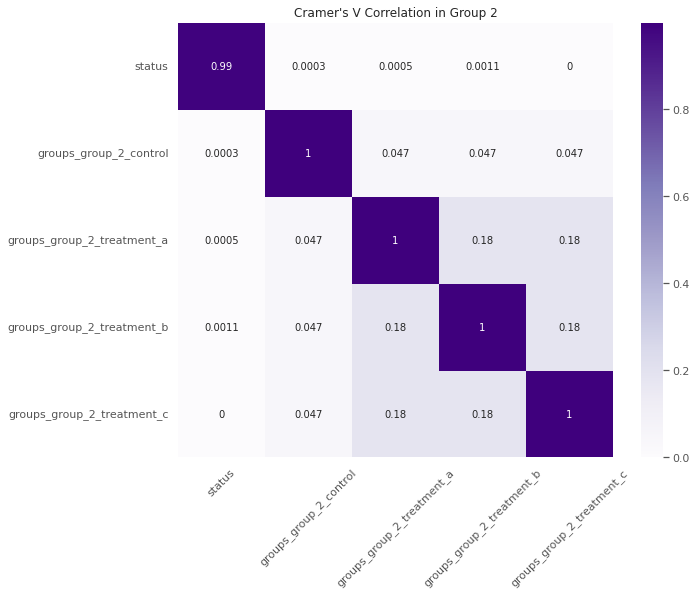

In [78]:
rows = []

for var1 in DataMatrix2:
    col = []
    for var2 in DataMatrix2:
        cramers = cramers_V(DataMatrix2[var1], DataMatrix2[var2])  # Cramer's V test
        col.append(round(cramers, 4))  # Keeping of the rounded value of the Cramer's V
    rows.append(col)

cramers_results = np.array(rows)
df2 = pd.DataFrame(
    cramers_results, columns=DataMatrix2.columns, index=DataMatrix2.columns
)

# mask = np.zeros_like(df, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(10, 8))

ax = sns.heatmap(df2, cmap="Purples", square=True, annot=True)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title("Cramer's V Correlation in Group 2", fontsize=12)


plt.show()

As the color shows in the hitmap, all the treatment groups have higher correlation with the activation status than the control group, treatment B notifications have the most correlation with the users' activation behavior in group 2.

#### 3.2.4.2 Activation in 14 Days 

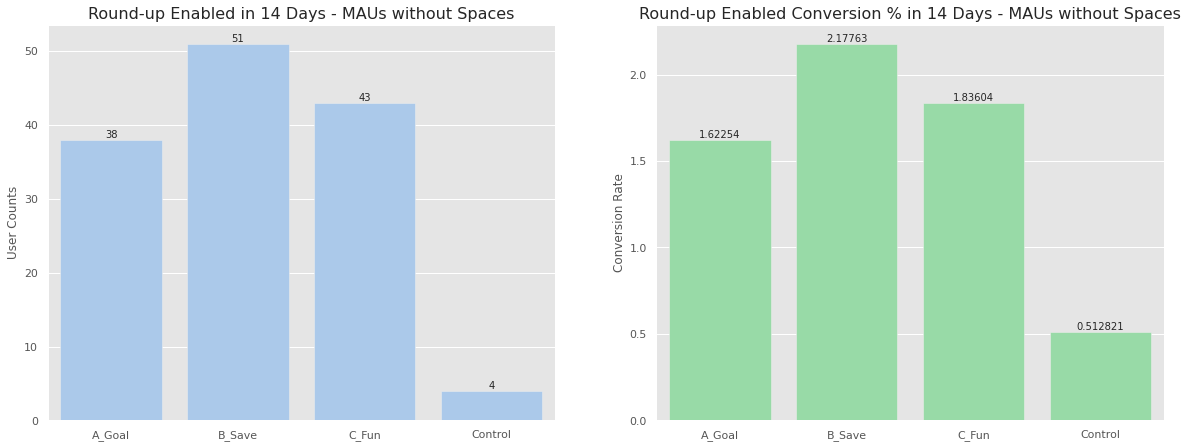

In [79]:
# plot the activation rate for each treatment groups and the control group
f = plt.subplots(figsize=(20, 16))
ax1 = plt.subplot(2, 2, 1)
sns.set_color_codes("pastel")
sns.barplot(
    x=["A_Goal", "B_Save", "C_Fun", "Control"],
    y=[
        rp_group_2_treatment_a_14d["status"].agg("count"),
        rp_group_2_treatment_b_14d["status"].agg("count"),
        rp_group_2_treatment_c_14d["status"].agg("count"),
        rp_group_2_control_14d["status"].agg("count"),
    ],
    ax=ax1,
    color="b",  # = "light:#5A9",
)
ax1.bar_label(ax1.containers[0])
ax1.set_title("Round-up Enabled in 14 Days - MAUs without Spaces", fontsize=16)
plt.ylabel("User Counts")

ax2 = plt.subplot(2, 2, 2)
sns.set_color_codes("pastel")
sns.barplot(
    x=["A_Goal", "B_Save", "C_Fun", "Control"],
    y=[
        100
        * rp_group_2_treatment_a_14d["status"].agg("count")
        / rp_group_2_treatment_a_14d["user_id"].agg("count"),
        100
        * rp_group_2_treatment_b_14d["status"].agg("count")
        / rp_group_2_treatment_b_14d["user_id"].agg("count"),
        100
        * rp_group_2_treatment_c_14d["status"].agg("count")
        / rp_group_2_treatment_c_14d["user_id"].agg("count"),
        100
        * rp_group_2_control_14d["status"].agg("count")
        / rp_group_2_control_14d["user_id"].agg("count"),
    ],
    ax=ax2,
    color="g",
)
ax2.bar_label(ax2.containers[0])
ax2.set_title(
    "Round-up Enabled Conversion % in 14 Days - MAUs without Spaces", fontsize=16
)
plt.ylabel("Conversion Rate")

plt.show()

Hypothesis Test: 
- Null hypothesis - in 14 days, there are no significant differences among the treatment groups and the control group
- Alternative hypothesis - in 14 days, there are significant differences among the treatment groups and the control group

In [80]:
# rename the activation status
rp_group_2_14d["status"] = rp_group_2_14d["status"].replace(np.NaN, 0)
rp_group_2_14d["status"] = rp_group_2_14d["status"].replace("ENABLED", 1)

In [81]:
# select sample info
group_2_status_14d = rp_group_2_14d["status"]
group_2_groups_14d = rp_group_2_14d["groups"]

In [82]:
# create the cross table
group_2_crosstab_14d = pd.crosstab(group_2_status_14d, group_2_groups_14d)

In [83]:
group_2_crosstab_14d

groups,group_2_control,group_2_treatment_a,group_2_treatment_b,group_2_treatment_c
status,,,,
0,776,2304,2291,2299
1,4,38,51,43


In [84]:
# calculate the row 1 col 1 chi square value, p value, df, and expected values
g2_14d_chiVal, g2_14d_pVal, g2_14d_df, g2_14d_exp = chi2_contingency(
    group_2_crosstab_14d
)

In [85]:
print(
    "At a significance level of 0.05, the first value of chi-sqaure value of",
    g2_14d_chiVal,
    ", the p-value is",
    g2_14d_pVal,
    ", the degree of freedom is",
    g2_14d_df,
    ", and the expected values are",
    g2_14d_exp.tolist(),
    ". \nTherefore, in 14 days window, ",
    end="",
)
if g2_14d_pVal > 0.05:
    print(
        "since the P value is > 0.05, we fail to reject the null hypothesis at the significance level of 0.05, and there are no significant differences among the treatment groups and the control group."
    )

else:
    print(
        "since the P value is < 0.05, we reject the null hypothesis, there are significant differences between these groups"
    )

At a significance level of 0.05, the first value of chi-sqaure value of 9.79650287521661 , the p-value is 0.020377547111400173 , the degree of freedom is 3 , and the expected values are [[766.4104534973097, 2301.1965155008966, 2301.1965155008966, 2301.1965155008966], [13.589546502690238, 40.803484499103256, 40.803484499103256, 40.803484499103256]] . 
Therefore, in 14 days window, since the P value is < 0.05, we reject the null hypothesis, there are significant differences between these groups


For users who have Spaces, but not round-up, our notifications still have effect on their activation behavior 14 days since they received the notification, while for users who do not have Spaces, the effect is not significant anymore in this window. 

In [86]:
# first chose your category columns of interest
df22 = rp_group_2_14d[["groups", "status"]]
# now change this to dummy variables, one-hot encoded:
DataMatrix22 = pd.get_dummies(df22)

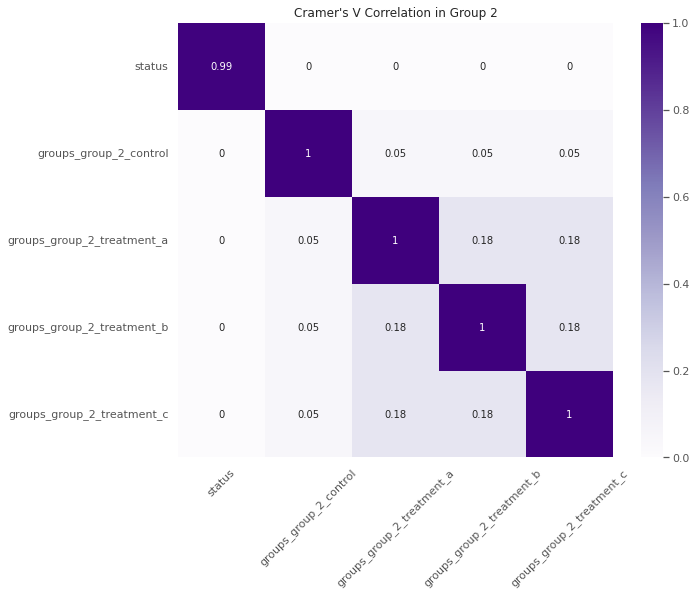

In [87]:
rows = []

for var1 in DataMatrix22:
    col = []
    for var2 in DataMatrix22:
        cramers = cramers_V(DataMatrix22[var1], DataMatrix22[var2])  # Cramer's V test
        col.append(round(cramers, 2))  # Keeping of the rounded value of the Cramer's V
    rows.append(col)

cramers_results = np.array(rows)
df22 = pd.DataFrame(
    cramers_results, columns=DataMatrix22.columns, index=DataMatrix22.columns
)

# mask = np.zeros_like(df, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(10, 8))

ax = sns.heatmap(df22, cmap="Purples", square=True, annot=True)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title("Cramer's V Correlation in Group 2", fontsize=12)


plt.show()

Treatment B notifications still affected the users behavior the most in group 2.

#### 3.2.4.3 Activation in 35 Days 

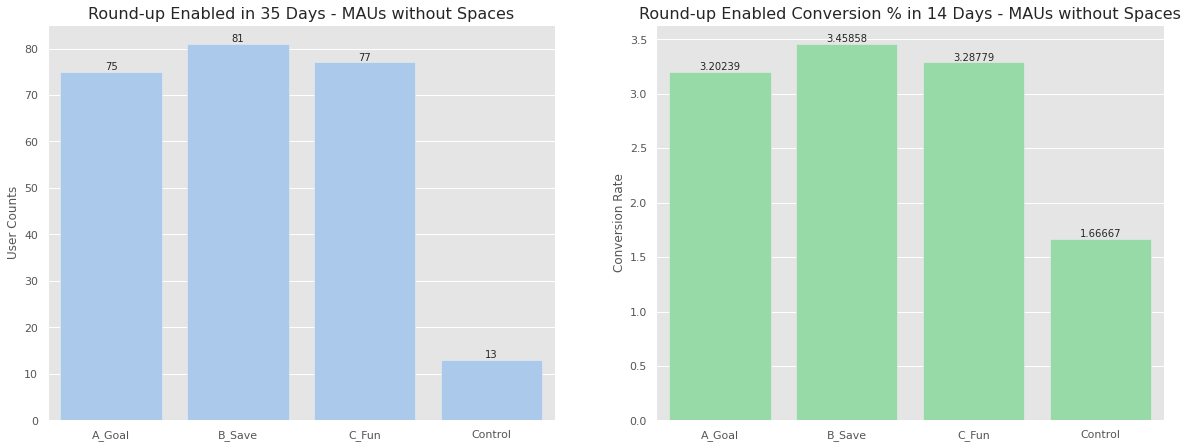

In [88]:
# plot the activation rate for each treatment groups and the control group
f = plt.subplots(figsize=(20, 16))
ax1 = plt.subplot(2, 2, 1)
sns.set_color_codes("pastel")
sns.barplot(
    x=["A_Goal", "B_Save", "C_Fun", "Control"],
    y=[
        rp_group_2_treatment_a_35d["status"].agg("count"),
        rp_group_2_treatment_b_35d["status"].agg("count"),
        rp_group_2_treatment_c_35d["status"].agg("count"),
        rp_group_2_control_35d["status"].agg("count"),
    ],
    ax=ax1,
    color="b",  # = "light:#5A9",
)
ax1.bar_label(ax1.containers[0])
ax1.set_title("Round-up Enabled in 35 Days - MAUs without Spaces", fontsize=16)
plt.ylabel("User Counts")

ax2 = plt.subplot(2, 2, 2)
sns.set_color_codes("pastel")
sns.barplot(
    x=["A_Goal", "B_Save", "C_Fun", "Control"],
    y=[
        100
        * rp_group_2_treatment_a_35d["status"].agg("count")
        / rp_group_2_treatment_a_35d["user_id"].agg("count"),
        100
        * rp_group_2_treatment_b_35d["status"].agg("count")
        / rp_group_2_treatment_b_35d["user_id"].agg("count"),
        100
        * rp_group_2_treatment_c_35d["status"].agg("count")
        / rp_group_2_treatment_c_35d["user_id"].agg("count"),
        100
        * rp_group_2_control_35d["status"].agg("count")
        / rp_group_2_control_35d["user_id"].agg("count"),
    ],
    ax=ax2,
    color="g",
)
ax2.bar_label(ax2.containers[0])
ax2.set_title(
    "Round-up Enabled Conversion % in 14 Days - MAUs without Spaces", fontsize=16
)
plt.ylabel("Conversion Rate")

plt.show()

Hypothesis Test: 
- Null hypothesis - in 35 days, there are no significant differences among the treatment groups and the control group
- Alternative hypothesis - in 35 days, there are significant differences among the treatment groups and the control group

In [89]:
# rename the activation status
rp_group_2_35d["status"] = rp_group_2_35d["status"].replace(np.NaN, 0)
rp_group_2_35d["status"] = rp_group_2_35d["status"].replace("ENABLED", 1)

In [90]:
# select sample info
group_2_status_35d = rp_group_2_35d["status"]
group_2_groups_35d = rp_group_2_35d["groups"]

In [91]:
# create the cross table
group_2_crosstab_35d = pd.crosstab(group_2_status_35d, group_2_groups_35d)

In [92]:
group_2_crosstab_35d

groups,group_2_control,group_2_treatment_a,group_2_treatment_b,group_2_treatment_c
status,,,,
0,767,2267,2261,2265
1,13,75,81,77


In [93]:
# calculate the row 1 col 1 chi square value, p value, df, and expected values
g2_35d_chiVal, g2_35d_pVal, g2_35d_df, g2_35d_exp = chi2_contingency(
    group_2_crosstab_35d
)

In [94]:
print(
    "The first value of chi-sqaure value of",
    g2_35d_chiVal,
    ", the p-value is",
    g2_35d_pVal,
    ", the degree of freedom is",
    g2_35d_df,
    ", and the expected values are",
    g2_14d_exp.tolist(),
    ". \nTherefore, in 35 days window, ",
    end="",
)
if g2_35d_pVal > 0.05:
    print(
        "since the P value is > 0.05, we fail to reject the null hypothesis at the significance level of 0.05, and there are no significant differences among the treatment groups and the control group."
    )
else:
    print(
        "since the P value is < 0.05, we reject the null hypothesis, there are significant differences between these groups"
    )

The first value of chi-sqaure value of 6.5204325731019095 , the p-value is 0.0888601674042113 , the degree of freedom is 3 , and the expected values are [[766.4104534973097, 2301.1965155008966, 2301.1965155008966, 2301.1965155008966], [13.589546502690238, 40.803484499103256, 40.803484499103256, 40.803484499103256]] . 
Therefore, in 35 days window, since the P value is > 0.05, we fail to reject the null hypothesis at the significance level of 0.05, and there are no significant differences among the treatment groups and the control group.


#### 3.2.4.4 Activation Trend

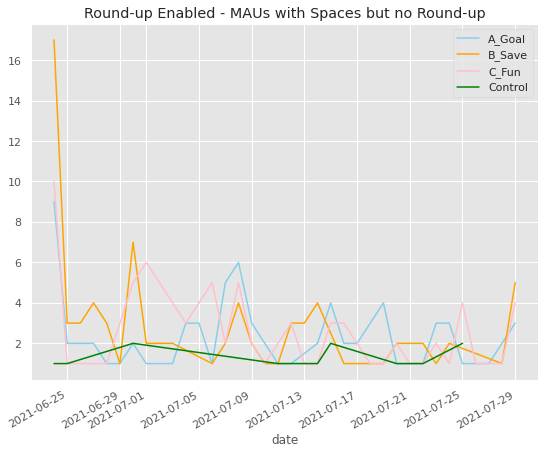

In [95]:
fig, ax = plt.subplots(figsize=(20, 16))

ax1 = plt.subplot(221)
rp_group_2_treatment_a_35d.groupby(["date"]).agg("count")["status"].plot(
    kind="line", label="A_Goal", color="skyblue", ax=ax1
)
rp_group_2_treatment_b_35d.groupby(["date"]).agg("count")["status"].plot(
    kind="line", label="B_Save", color="orange", ax=ax1
)
rp_group_2_treatment_c_35d.groupby(["date"]).agg("count")["status"].plot(
    kind="line", label="C_Fun", color="pink", ax=ax1
)
rp_group_2_control_35d.groupby(["date"]).agg("count")["status"].plot(
    kind="line", label="Control", color="green", ax=ax1
)
ax1.set_title("Round-up Enabled - MAUs with Spaces but no Round-up")
plt.legend(loc="best")

plt.show()

Note: 
For transactions, all the analysis below are fall into a 35 days window. 

### 3.3 Transaction since Receiving the Notification by Group

In [96]:
# import out going card transactions a MAU period before June 24th, later will be join users who receive the notifications
txn = """
select 
    user_id, 
    date(completed_tstamp) txn_date, 
    abs(f.bank_balance_impact) txn_amount
from 
    dbt.f_transactions f
where 
    type = 'Card' and 
    direction = 'Outgoing' and 
    date(completed_tstamp) >= '2021-06-24' and 
    date(completed_tstamp) <= '2021-07-29'
"""
txn = df_from_sql("redshiftreader", txn)

{"message": "started", "db": "redshiftreader", "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 126, "funcName": "df_from_sql", "created": "20210924T044615", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "d68a1247-43bb-40d3-b6d8-05993c8a3abf", "hostname": "172.18.0.4"}
{"message": "success", "db": "redshiftreader", "duration": 7.1296, "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 136, "funcName": "df_from_sql", "created": "20210924T044622", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "d68a1247-43bb-40d3-b6d8-05993c8a3abf", "hostname": "172.18.0.4"}


In [97]:
txn["txn_date"] = pd.to_datetime(txn["txn_date"])

In [98]:
# merge all dates data using user_id, so I know which one did not make transactions
tx_group_1_treatment_a = pd.merge(
    left=group_1_treatment_a, right=txn, how="left", on=["user_id"]
)
tx_group_1_treatment_b = pd.merge(
    left=group_1_treatment_b, right=txn, how="left", on=["user_id"]
)
tx_group_1_treatment_c = pd.merge(
    left=group_1_treatment_c, right=txn, how="left", on=["user_id"]
)
tx_group_1_control = pd.merge(
    left=group_1_control, right=txn, how="left", on=["user_id"]
)
tx_group_2_treatment_a = pd.merge(
    left=group_2_treatment_a, right=txn, how="left", on=["user_id"]
)
tx_group_2_treatment_b = pd.merge(
    left=group_2_treatment_b, right=txn, how="left", on=["user_id"]
)
tx_group_2_treatment_c = pd.merge(
    left=group_2_treatment_c, right=txn, how="left", on=["user_id"]
)
tx_group_2_control = pd.merge(
    left=group_2_control, right=txn, how="left", on=["user_id"]
)

In [99]:
# combine the treatment and control groups together with all dates
tx_group_1 = pd.concat(
    [
        tx_group_1_treatment_a,
        tx_group_1_treatment_b,
        tx_group_1_treatment_c,
        tx_group_1_control,
    ]
)
tx_group_2 = pd.concat(
    [
        tx_group_2_treatment_a,
        tx_group_2_treatment_b,
        tx_group_2_treatment_c,
        tx_group_2_control,
    ]
)
# have a complete dateframe in case I need it in the following analysis

### 3.3.1 Group 1 and Group 2, which one performs better in terms of transactions?

#### 3.3.1.1 Do users make transactions after receiving the notifications

In [100]:
# create a new column to store transaction status
tx_group_1["cat"] = "cat_group_1"
tx_group_2["cat"] = "cat_group_2"

In [101]:
# create a new column to store transaction status
tx_group_1["txn_status"] = tx_group_1["txn_date"]
tx_group_2["txn_status"] = tx_group_2["txn_date"]

In [102]:
tx_group_1["txn_status"] = tx_group_1["txn_status"].replace(np.NaN, 0)
tx_group_2["txn_status"] = tx_group_2["txn_status"].replace(np.NaN, 0)

In [103]:
# modify the column txn_status by marketing it as yes - made transactions, no-no transactions
def txn_lab(tx_group_1):
    if tx_group_1["txn_status"] == 0:
        return 0
    else:
        return 1


tx_group_1["txn_status"] = tx_group_1.apply(
    lambda tx_group_1: txn_lab(tx_group_1), axis=1
)

In [104]:
# modify the column txn_status by marketing it as yes - made transactions, no-no transactions
def txn_lab(tx_group_2):
    if tx_group_2["txn_status"] == 0:
        return 0
    else:
        return 1


tx_group_2["txn_status"] = tx_group_2.apply(
    lambda tx_group_2: txn_lab(tx_group_2), axis=1
)

In [105]:
# since we are testing weather or not here, we remove the duplicate transaction counts for same users
txn_or_not_1 = tx_group_1.sort_values("txn_date", ascending=True)
txn_or_not_1 = tx_group_1.drop_duplicates(subset="user_id", keep="first")
txn_or_not_2 = tx_group_2.sort_values("txn_date", ascending=True)
txn_or_not_2 = tx_group_2.drop_duplicates(subset="user_id", keep="first")

In [106]:
txn_or_not = pd.concat([txn_or_not_1, txn_or_not_2])

In [107]:
# select sample info
txn_or_not_status = txn_or_not["txn_status"]
txn_or_not_cat = txn_or_not["cat"]

In [108]:
# create the cross table
txn_or_not_crosstab = pd.crosstab(txn_or_not_status, txn_or_not_cat)
txn_or_not_crosstab

cat,cat_group_1,cat_group_2
txn_status,,
0,3293,2348
1,4897,5458


In [109]:
# calculate the row 1 col 1 chi square value, p value, df, and expected values
tx_chiVal, tx_pVal, tx_df, tx_exp = chi2_contingency(txn_or_not_crosstab)

In [185]:
print(
    "At a significance level of 0.05, the first value of chi-square value of",
    tx_chiVal,
    ", the p-value is",
    tx_pVal,
    ", the degree of freedom is",
    tx_df,
    ", and the expected values are",
    tx_exp.tolist(),
    end="",
)
if tx_pVal > 0.05:
    print(
        "since the P value is > 0.05, we fail to reject the null hypothesis at the significance level of 0.05, and there are no differences among the treatment groups and the control group."
    )

else:
    print(
        "since the P value is < 0.05, we reject the null hypothesis, there are significant differences between these groups."
    )

At a significance level of 0.05, the first value of chi-square value of 179.1446480406925 , the p-value is 7.450420019362694e-41 , the degree of freedom is 1 , and the expected values are [[2888.208927231808, 2752.791072768192], [5301.791072768192, 5053.208927231808]]since the P value is < 0.05, we reject the null hypothesis, there are significant differences between these groups.


In [111]:
# test the control group
n1_control = tx_group_1_control.user_id.count()
n2_control = tx_group_2_control.user_id.count()
p1 = tx_group_1_control.txn_date.count() / n1_control
p2 = tx_group_2_control.txn_date.count() / n2_control
p = np.mean([p1, p2])
z = ((p1 - p2) - 0) / np.sqrt(p * (1 - p) * (1 / n1_control + 1 / n2_control))

In [112]:
# calculate the p_value
p_values = st.norm.sf(abs(z))

In [184]:
# return the result with a significance level of 0.01
if p_values > 0.01:
    print(
        "P value equals",
        p_values,
        ", fail to reject the null hypothesis, there are no significant difference between these two groups",
    )
else:
    print(
        "P value equals",
        p_values,
        ", reject the null hypothesis, there are significant difference between these two groups",
    )

P value equals 1.0422422154587605e-09 , reject the null hypothesis, there are significant difference between these two groups


From the test above, we can conclude that transaction activity in group 2 is more active organically without the treatments.

#### 3.3.1.2 How many transactions per user since they received the notifications

In [114]:
# f = plt.subplots(figsize=(20,16))
# ax1 = plt.subplot(2,2,1)
# s1 = tx_group_1.groupby(['cat']).agg('sum')['txn_status']/8190
# s2 = tx_group_2.groupby(['cat']).agg('sum')['txn_status']/7806

# s1.plot(kind = 'bar', alpha=0.7, label = 'MAUs without Spaces', color = 'skyblue', ax = ax1)
# s2.plot(kind = 'bar', alpha=0.5, label = 'MAUs with Spaces but no Round-up', color = 'pink', ax = ax1)

# plt.ylabel("Transaction Count")
# ax1.bar_label(ax1.containers[0])
# ax1.set_title('Average Transaction Counts Trend')
# plt.legend(loc='upper right')

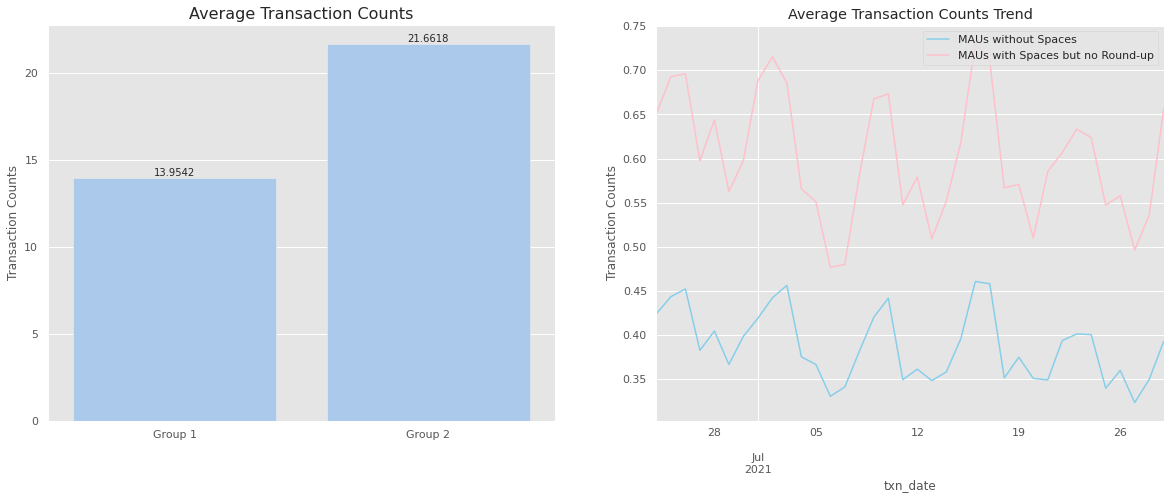

In [115]:
# plot total amount and trend of transaction counts
f = plt.subplots(figsize=(20, 16))

ax1 = plt.subplot(2, 2, 1)
sns.set_color_codes("pastel")
sns.barplot(
    x=["Group 1", "Group 2"],
    y=[
        tx_group_1["txn_date"].agg("count") / 8190,
        tx_group_2["txn_date"].agg("count") / 7806,
    ],
    ax=ax1,
    color="b",
)
ax1.bar_label(ax1.containers[0])
ax1.set_title("Average Transaction Counts", fontsize=16)
plt.ylabel("Transaction Counts")

g1 = tx_group_1.groupby(["txn_date"]).agg("count")["txn_amount"] / 8190
g2 = tx_group_2.groupby(["txn_date"]).agg("count")["txn_amount"] / 7806

ax2 = plt.subplot(2, 2, 2)
g1.plot(kind="line", label="MAUs without Spaces", color="skyblue", ax=ax2)
g2.plot(kind="line", label="MAUs with Spaces but no Round-up", color="pink", ax=ax2)
plt.ylabel("Transaction Counts")
ax2.set_title("Average Transaction Counts Trend")
plt.legend(loc="upper right")

plt.show()

In [116]:
# group transaction counts by user_id
tx_cnt_group_1 = tx_group_1.groupby(["user_id"]).agg("sum")["txn_status"]
tx_cnt_group_2 = tx_group_2.groupby(["user_id"]).agg("sum")["txn_status"]

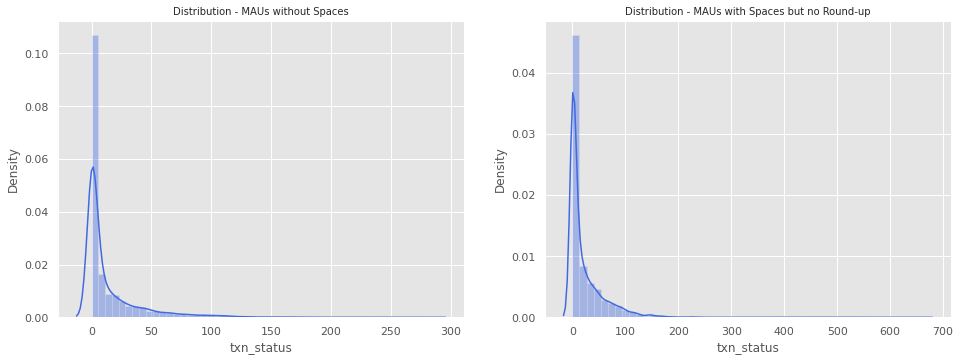

In [117]:
# check the distribution
fig = plt.subplots(figsize=(16, 12))

ax1 = plt.subplot(221)
sns.distplot(tx_cnt_group_1, color="royalblue", ax=ax1)
ax1.set_title("Distribution - MAUs without Spaces", fontsize=10)

ax2 = plt.subplot(222)
sns.distplot(tx_cnt_group_2, color="royalblue", ax=ax2)
ax2.set_title("Distribution - MAUs with Spaces but no Round-up", fontsize=10)

plt.show()

Hypothesis Test to analyse the mean of users transaction counts after receiving the notification
- Null hypothesis - average transaction counts for MAUs who has spaces <= MAUs who do not have spaces
- Alternative hypothesis - average transaction counts for MAUs who has spaces > MAUs who do not have spaces

In [118]:
# hypothesiscompare different for two testing groups
t_test, pval_oneside = stats.ttest_ind(
    tx_cnt_group_2, tx_cnt_group_1, alternative="greater"
)
alpha = 0.05
if pval_oneside < alpha:
    print(
        "Reject the null hypothesis, average transaction counts of MAUs who has spaces' is significantly more than MAUs who do not have spaces."
    )
else:
    print(
        "Fail to reject the null hypothesis, average transaction counts of MAUs who has spaces is not significantly more than MAUs who do not have spaces."
    )

Reject the null hypothesis, average transaction counts of MAUs who has spaces' is significantly more than MAUs who do not have spaces.


In [119]:
# group transaction counts by user_id
tx_cnt_group_1_control = tx_group_1_control.groupby(["user_id"]).agg("count")[
    "txn_date"
]
tx_cnt_group_2_control = tx_group_2_control.groupby(["user_id"]).agg("count")[
    "txn_date"
]

In [120]:
# hypothesiscompare different for two testing groups
t_test, pval_oneside = stats.ttest_ind(
    tx_cnt_group_2_control, tx_cnt_group_1_control, alternative="greater"
)
alpha = 0.05
if pval_oneside < alpha:
    print(
        "Reject the null hypothesis, average transaction counts of MAUs who has spaces' is significantly more than MAUs who do not have spaces."
    )
else:
    print(
        "Fail to reject the null hypothesis, average transaction counts of MAUs who have spaces is not significantly more than MAUs who do not have spaces."
    )

Reject the null hypothesis, average transaction counts of MAUs who has spaces' is significantly more than MAUs who do not have spaces.


From the above analysis, in terms of transaction amount, MAUs with spaces make more transactions than MAUs who do not have spaces, regardless of receiving the notifications or not.

#### 3.3.1.3 What is the average transaction amount since they received the notifications

In [121]:
# tx_group = pd.concat([tx_group_1, tx_group_2])

In [122]:
tx_amt_group_1 = tx_group_1[["user_id", "txn_amount"]].groupby(["user_id"]).agg("mean")
tx_amt_group_2 = tx_group_2[["user_id", "txn_amount"]].groupby(["user_id"]).agg("mean")

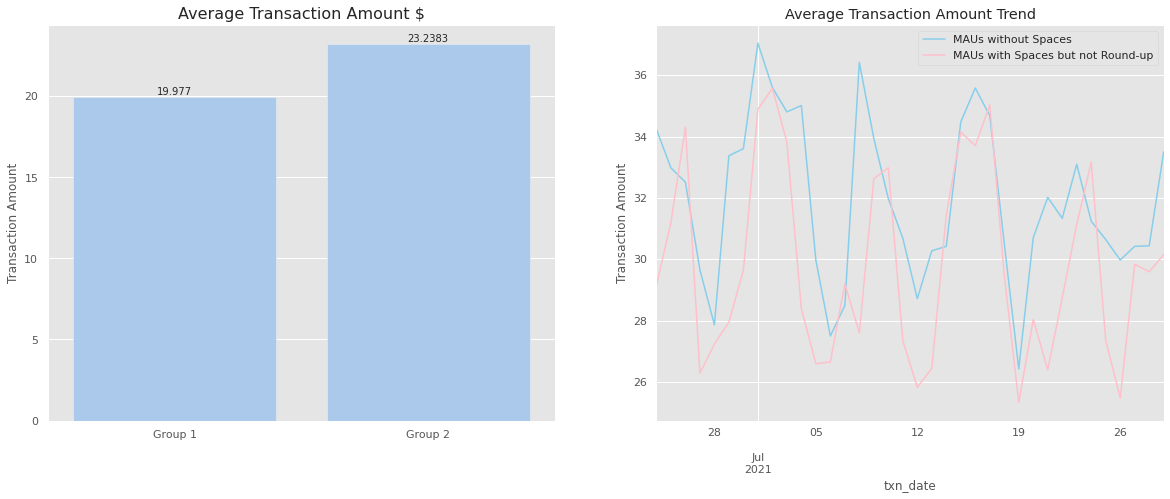

In [123]:
# plot total amount and trend of transaction counts
f = plt.subplots(figsize=(20, 16))

ax1 = plt.subplot(2, 2, 1)
sns.set_color_codes("pastel")
sns.barplot(
    x=["Group 1", "Group 2"],
    y=[
        tx_amt_group_1.txn_amount.agg("sum") / 8190,
        tx_amt_group_2.txn_amount.agg("sum") / 7806,
    ],
    ax=ax1,
    color="b",
)
ax1.bar_label(ax1.containers[0])
ax1.set_title("Average Transaction Amount $", fontsize=16)
plt.ylabel("Transaction Amount")

g1 = tx_group_1.groupby(["txn_date"]).agg("mean")["txn_amount"]
g2 = tx_group_2.groupby(["txn_date"]).agg("mean")["txn_amount"]

ax2 = plt.subplot(2, 2, 2)
g1.plot(kind="line", label="MAUs without Spaces", color="skyblue", ax=ax2)
g2.plot(kind="line", label="MAUs with Spaces but not Round-up", color="pink", ax=ax2)
plt.ylabel("Transaction Amount")
ax2.set_title("Average Transaction Amount Trend")
plt.legend(loc="upper right")

plt.show()

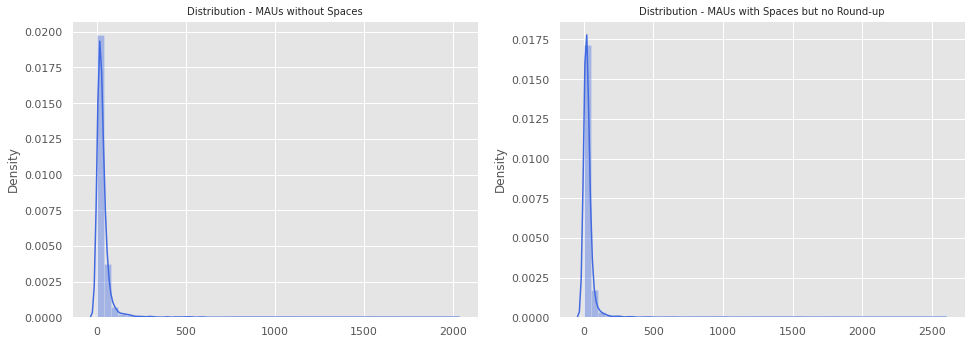

In [124]:
# check the distribution
fig = plt.subplots(figsize=(16, 12))

ax1 = plt.subplot(221)
sns.distplot(tx_amt_group_1, color="royalblue", ax=ax1)
ax1.set_title("Distribution - MAUs without Spaces", fontsize=10)

ax2 = plt.subplot(222)
sns.distplot(tx_amt_group_2, color="royalblue", ax=ax2)
ax2.set_title("Distribution - MAUs with Spaces but no Round-up", fontsize=10)

plt.show()

Hypothesis Test to analyse the mean of users transaction amount after receiving the notification
- Null hypothesis - average transaction amount for MAUs who has spaces <= MAUs who do not have spaces
- Alternative hypothesis - average transaction amount for MAUs who has spaces > MAUs who do not have spaces

In [125]:
# hypothesiscompare different for two testing groups
t_test, pval_oneside = stats.ttest_ind(
    tx_amt_group_2, tx_amt_group_1, alternative="greater"
)
alpha = 0.05
if pval_oneside < alpha:
    print(
        "Reject the null hypothesis, transaction counts of MAUs who has spaces' is significantly more than MAUs who do not have spaces."
    )
else:
    print(
        "Fail to reject the null hypothesis, transaction counts of MAUs who have spaces is not significantly more than MAUs who do not have spaces."
    )

Fail to reject the null hypothesis, transaction counts of MAUs who has spaces is not significantly more than MAUs who do not have spaces.


### 3.3.2 Group 1, which treatment groups performs better in terms of transactions?

#### 3.3.2.1 Do users make transactions after receiving the notifications

In [126]:
# select sample info
txn_or_not_1_status = txn_or_not_1["txn_status"]
txn_or_not_1_groups = txn_or_not_1["groups"]

In [127]:
# create the cross table
txn_or_not_1_crosstab = pd.crosstab(
    txn_or_not_1_groups,
    txn_or_not_1_status,
)
txn_or_not_1_crosstab

txn_status,0,1
groups,,
group_1_control,307,512
group_1_treatment_a,1039,1418
group_1_treatment_b,969,1488
group_1_treatment_c,978,1479


In [128]:
# calculate the row 1 col 1 chi square value, p value, df, and expected values
g1_tx_chiVal, g1_tx_pVal, g1_tx_df, g1_tx_exp = chi2_contingency(txn_or_not_1_crosstab)

In [129]:
print(
    "The first value of chi-square value of",
    g1_tx_chiVal,
    ", the p-value is",
    g1_tx_pVal,
    ", the degree of freedom is",
    g1_tx_df,
    ", and the expected values are",
    g1_tx_exp.tolist(),
    end="",
)
if g1_tx_pVal > 0.05:
    print(
        "since the P value is > 0.05, we fail to reject the null hypothesis at the significance level of 0.05, and there are no differences among the treatment groups and the control group."
    )

else:
    print(
        "since the P value is < 0.05, we reject the null hypothesis, there are significant differences between these groups."
    )

The first value of chi-sqaure value of 7.716915002343137 , the p-value is 0.05223926050481905 , the degree of freedom is 3 , and the expected values are [[329.3, 489.7], [987.9, 1469.1], [987.9, 1469.1], [987.9, 1469.1]] . 
Therefore, in 7 days window, since the P value is > 0.05, we fail to reject the null hypothesis at the significance level of 0.05, and there are no differences among the treatment groups and the control group.


#### 3.3.2.2 How many transactions per user since they received the notifications

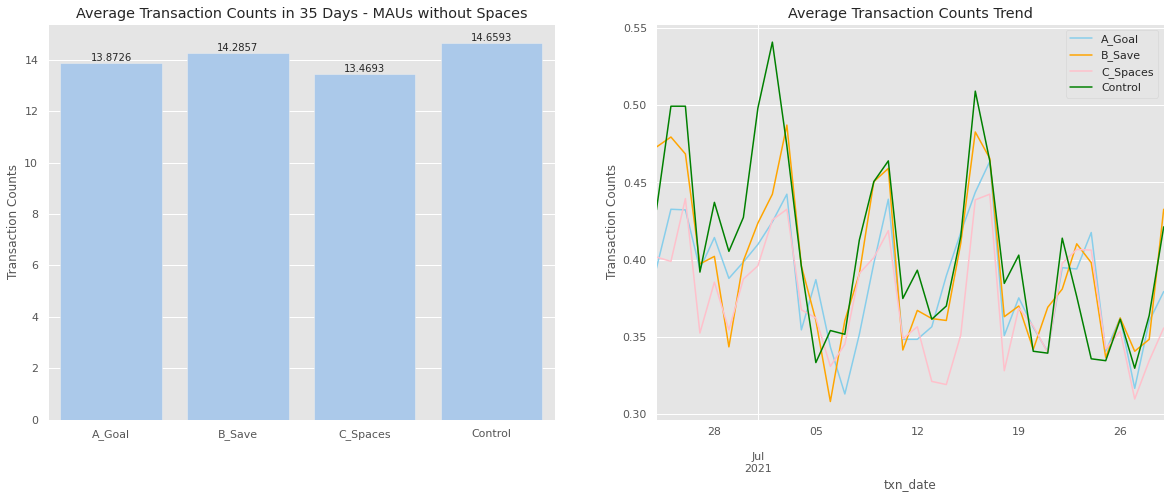

In [130]:
# plot total transaction counts

f = plt.subplots(figsize=(20, 16))

ax1 = plt.subplot(2, 2, 1)
sns.set_color_codes("pastel")
sns.barplot(
    x=["A_Goal", "B_Save", "C_Spaces", "Control"],
    y=[
        tx_group_1_treatment_a["txn_amount"].agg("count") / 2457,
        tx_group_1_treatment_b["txn_amount"].agg("count") / 2457,
        tx_group_1_treatment_c["txn_amount"].agg("count") / 2457,
        tx_group_1_control["txn_amount"].agg("count") / 819,
    ],
    ax=ax1,
    color="b",
)
ax1.bar_label(ax1.containers[0])
ax1.set_title("Average Transaction Counts in 35 Days - MAUs without Spaces")
plt.ylabel("Transaction Counts")

g1 = tx_group_1_treatment_a.groupby(["txn_date"]).agg("count")["txn_amount"] / 2457
g2 = tx_group_1_treatment_b.groupby(["txn_date"]).agg("count")["txn_amount"] / 2457
g3 = tx_group_1_treatment_c.groupby(["txn_date"]).agg("count")["txn_amount"] / 2457
g4 = tx_group_1_control.groupby(["txn_date"]).agg("count")["txn_amount"] / 819

ax2 = plt.subplot(2, 2, 2)
g1.plot(kind="line", label="A_Goal", color="skyblue", ax=ax2)
g2.plot(kind="line", label="B_Save", color="orange", ax=ax2)
g3.plot(kind="line", label="C_Spaces", color="pink", ax=ax2)
g4.plot(kind="line", label="Control", color="green", ax=ax2)
plt.ylabel("Transaction Counts")
ax2.set_title("Average Transaction Counts Trend")
plt.legend(loc="upper right")


plt.show()

#### 3.3.2.3 What is the average transaction amount since they received the notifications

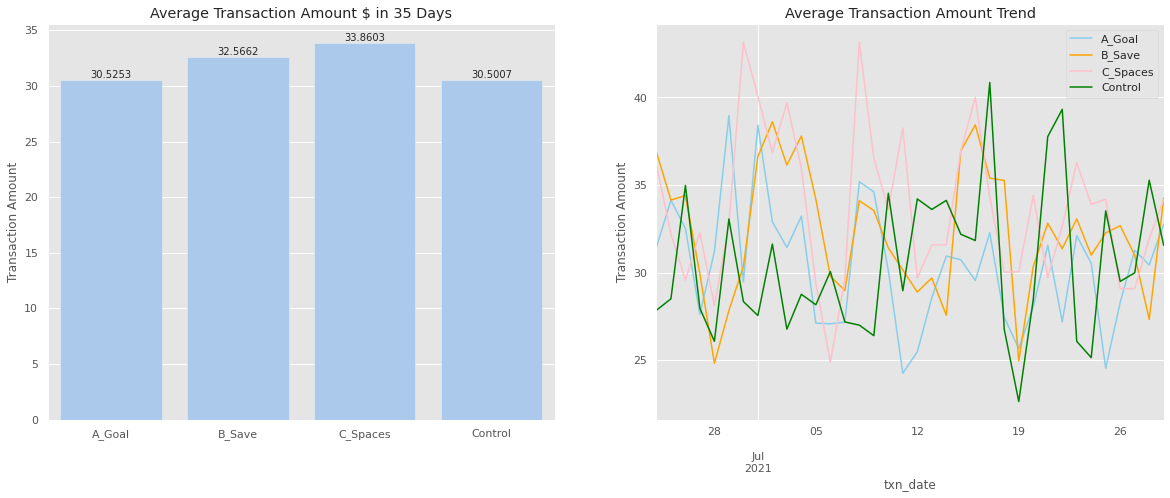

In [131]:
# plot total transaction counts

f = plt.subplots(figsize=(20, 16))

ax1 = plt.subplot(2, 2, 1)
sns.set_color_codes("pastel")
sns.barplot(
    x=["A_Goal", "B_Save", "C_Spaces", "Control"],
    y=[
        tx_group_1_treatment_a["txn_amount"].agg("mean"),
        tx_group_1_treatment_b["txn_amount"].agg("mean"),
        tx_group_1_treatment_c["txn_amount"].agg("mean"),
        tx_group_1_control["txn_amount"].agg("mean"),
    ],
    ax=ax1,
    color="b",
)
ax1.bar_label(ax1.containers[0])
ax1.set_title("Average Transaction Amount $ in 35 Days")
plt.ylabel("Transaction Amount")

g1 = tx_group_1_treatment_a.groupby(["txn_date"]).agg("mean")["txn_amount"]
g2 = tx_group_1_treatment_b.groupby(["txn_date"]).agg("mean")["txn_amount"]
g3 = tx_group_1_treatment_c.groupby(["txn_date"]).agg("mean")["txn_amount"]
g4 = tx_group_1_control.groupby(["txn_date"]).agg("mean")["txn_amount"]

ax2 = plt.subplot(2, 2, 2)
g1.plot(kind="line", label="A_Goal", color="skyblue", ax=ax2)
g2.plot(kind="line", label="B_Save", color="orange", ax=ax2)
g3.plot(kind="line", label="C_Spaces", color="pink", ax=ax2)
g4.plot(kind="line", label="Control", color="green", ax=ax2)
plt.ylabel("Transaction Amount")
ax2.set_title("Average Transaction Amount Trend")
plt.legend(loc="upper right")


plt.show()

Since treatment groups do not have any effect on transactions, I do not conduct more hypothesis here to analyze transaction amount and transaction counts. 

### 3.3.3 Group 2, which treatment groups performs better in terms of transactions?

#### 3.3.3.1 Do users make transactions after receiving the notifications

In [132]:
# select sample info
txn_or_not_2_status = txn_or_not_2["txn_status"]
txn_or_not_2_groups = txn_or_not_2["groups"]

In [133]:
# create the cross table
txn_or_not_2_crosstab = pd.crosstab(
    txn_or_not_2_groups,
    txn_or_not_2_status,
)
txn_or_not_2_crosstab

txn_status,0,1
groups,,
group_2_control,245,535
group_2_treatment_a,725,1617
group_2_treatment_b,683,1659
group_2_treatment_c,695,1647


In [134]:
# calculate the row 1 col 1 chi square value, p value, df, and expected values
g2_tx_chiVal, g2_tx_pVal, g2_tx_df, g2_tx_exp = chi2_contingency(txn_or_not_2_crosstab)

In [135]:
print(
    "The first value of chi-square value of",
    g2_tx_chiVal,
    ", the p-value is",
    g2_tx_pVal,
    ", the degree of freedom is",
    g2_tx_df,
    ", and the expected values are",
    g2_tx_exp.tolist(),
    ". \nTherefore, in 7 days window, ",
    end="",
)
if g2_tx_pVal > 0.05:
    print(
        "since the P value is > 0.05, we fail to reject the null hypothesis at the significance level of 0.05, and there are no differences among the treatment groups and the control group."
    )

else:
    print(
        "since the P value is < 0.05, we reject the null hypothesis, there are significant differences between these groups."
    )

The first value of chi-sqaure value of 2.630035873839763 , the p-value is 0.45224818547430223 , the degree of freedom is 3 , and the expected values are [[234.619523443505, 545.380476556495], [704.460158852165, 1637.539841147835], [704.460158852165, 1637.539841147835], [704.460158852165, 1637.539841147835]] . 
Therefore, in 7 days window, since the P value is > 0.05, we fail to reject the null hypothesis at the significance level of 0.05, and there are no differences among the treatment groups and the control group.


#### 3.3.3.2 How many transactions per user since they received the notifications

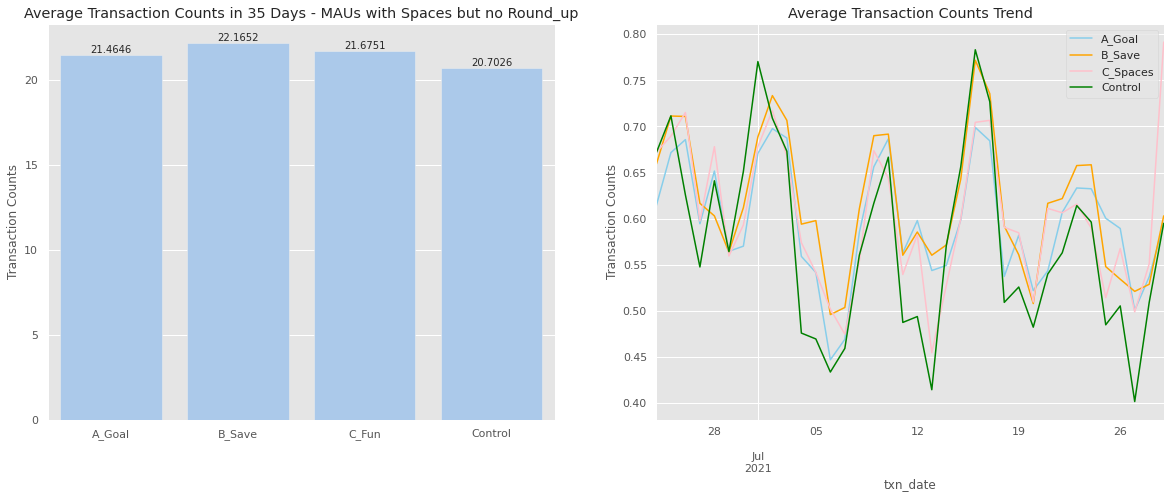

In [136]:
# plot total transaction counts

f = plt.subplots(figsize=(20, 16))

ax1 = plt.subplot(2, 2, 1)
sns.set_color_codes("pastel")
sns.barplot(
    x=["A_Goal", "B_Save", "C_Fun", "Control"],
    y=[
        tx_group_2_treatment_a["txn_amount"].agg("count") / 2342,
        tx_group_2_treatment_b["txn_amount"].agg("count") / 2342,
        tx_group_2_treatment_c["txn_amount"].agg("count") / 2342,
        tx_group_2_control["txn_amount"].agg("count") / 780,
    ],
    ax=ax1,
    color="b",
)
ax1.bar_label(ax1.containers[0])
ax1.set_title(
    "Average Transaction Counts in 35 Days - MAUs with Spaces but no Round_up"
)
plt.ylabel("Transaction Counts")

g1 = tx_group_2_treatment_a.groupby(["txn_date"]).agg("count")["txn_amount"] / 2342
g2 = tx_group_2_treatment_b.groupby(["txn_date"]).agg("count")["txn_amount"] / 2342
g3 = tx_group_2_treatment_c.groupby(["txn_date"]).agg("count")["txn_amount"] / 2342
g4 = tx_group_2_control.groupby(["txn_date"]).agg("count")["txn_amount"] / 780

ax2 = plt.subplot(2, 2, 2)
g1.plot(kind="line", label="A_Goal", color="skyblue", ax=ax2)
g2.plot(kind="line", label="B_Save", color="orange", ax=ax2)
g3.plot(kind="line", label="C_Spaces", color="pink", ax=ax2)
g4.plot(kind="line", label="Control", color="green", ax=ax2)
plt.ylabel("Transaction Counts")
ax2.set_title("Average Transaction Counts Trend")
plt.legend(loc="upper right")

plt.show()

#### 3.3.3.3 What is the average transaction amount since they received the notifications

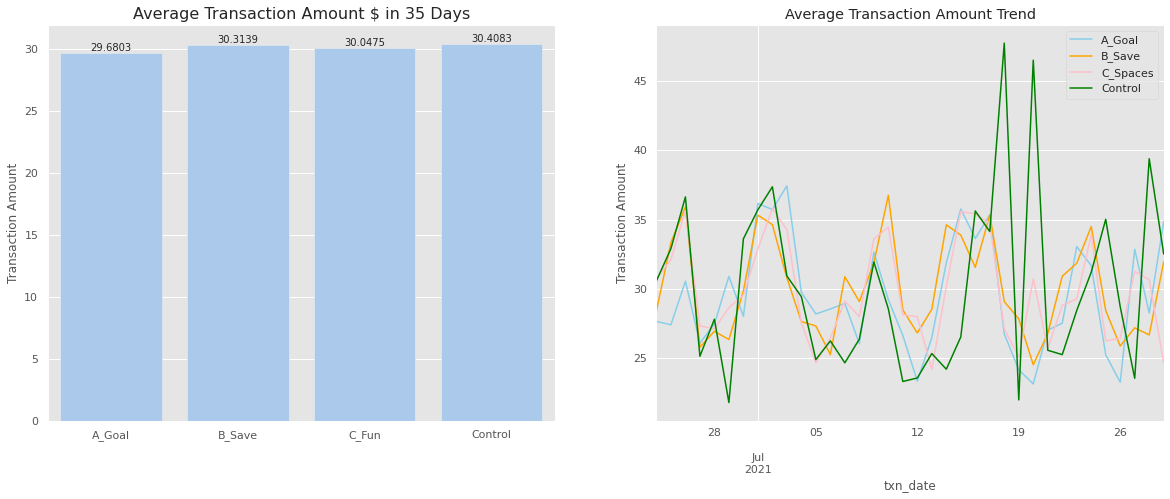

In [137]:
# plot total transaction counts

f = plt.subplots(figsize=(20, 16))

ax1 = plt.subplot(2, 2, 1)
sns.set_color_codes("pastel")
sns.barplot(
    x=["A_Goal", "B_Save", "C_Fun", "Control"],
    y=[
        tx_group_2_treatment_a["txn_amount"].agg("mean"),
        tx_group_2_treatment_b["txn_amount"].agg("mean"),
        tx_group_2_treatment_c["txn_amount"].agg("mean"),
        tx_group_2_control["txn_amount"].agg("mean"),
    ],
    ax=ax1,
    color="b",
)
ax1.bar_label(ax1.containers[0])
ax1.set_title("Average Transaction Amount $ in 35 Days", fontsize=16)
plt.ylabel("Transaction Amount")

g1 = tx_group_2_treatment_a.groupby(["txn_date"]).agg("mean")["txn_amount"]
g2 = tx_group_2_treatment_b.groupby(["txn_date"]).agg("mean")["txn_amount"]
g3 = tx_group_2_treatment_c.groupby(["txn_date"]).agg("mean")["txn_amount"]
g4 = tx_group_2_control.groupby(["txn_date"]).agg("mean")["txn_amount"]

ax2 = plt.subplot(2, 2, 2)
g1.plot(kind="line", label="A_Goal", color="skyblue", ax=ax2)
g2.plot(kind="line", label="B_Save", color="orange", ax=ax2)
g3.plot(kind="line", label="C_Spaces", color="pink", ax=ax2)
g4.plot(kind="line", label="Control", color="green", ax=ax2)
plt.ylabel("Transaction Amount")
ax2.set_title("Average Transaction Amount Trend")
plt.legend(loc="upper right")


plt.show()

Same as group 1, the treatment groups do not have any effect on transactions, so I do not conduct more hypothesis here to analyze transaction amount and transaction count.

### 3.4 Transaction of Users who Received the Notification and Activated Round-up

In [138]:
# import transactions of users who have roundup enabled after Notification sent and transactions after roundup up
rp_txn = """
with r as (
select
    distinct user_id,
    date(created) rp_created,
    id
from
    cn_automated_rule
where
    action_type = 'ROUND_UP' and 
    status = 'ENABLED' and 
    date(created) >= '2021-06-24' 
)
select 
    r.user_id, 
    date(r.rp_created) rp_date, 
    date(f.completed_tstamp) txn_date, 
    abs(f.bank_balance_impact) txn_amount
from 
    dbt.f_transactions f
right join r on
    r.user_id = f.user_id
    and 
    completed_tstamp >= r.rp_created
where
    type = 'Card' and 
    direction = 'Outgoing' and 
    date(completed_tstamp) <= '2021-07-29'
"""
rp_txn = df_from_sql("redshiftreader", rp_txn)

{"message": "started", "db": "redshiftreader", "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 126, "funcName": "df_from_sql", "created": "20210924T044638", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "d68a1247-43bb-40d3-b6d8-05993c8a3abf", "hostname": "172.18.0.4"}
{"message": "success", "db": "redshiftreader", "duration": 4.2037, "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 136, "funcName": "df_from_sql", "created": "20210924T044642", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "d68a1247-43bb-40d3-b6d8-05993c8a3abf", "hostname": "172.18.0.4"}


In [139]:
rp_txn["txn_date"] = pd.to_datetime(rp_txn["txn_date"])

### 3.4.1 Group 1 and Group 2, which one performs better in terms of transactions after receiving the notification and activating round_up?

In [140]:
# merge all dates data using user_id, so I know which one did not make transactions
rp_tx_group_1_treatment_a = pd.merge(
    left=group_1_treatment_a, right=rp_txn, how="inner", on=["user_id"]
)
rp_tx_group_1_treatment_b = pd.merge(
    left=group_1_treatment_b, right=rp_txn, how="inner", on=["user_id"]
)
rp_tx_group_1_treatment_c = pd.merge(
    left=group_1_treatment_c, right=rp_txn, how="inner", on=["user_id"]
)
rp_tx_group_1_control = pd.merge(
    left=group_1_control, right=rp_txn, how="inner", on=["user_id"]
)
rp_tx_group_2_treatment_a = pd.merge(
    left=group_2_treatment_a, right=rp_txn, how="inner", on=["user_id"]
)
rp_tx_group_2_treatment_b = pd.merge(
    left=group_2_treatment_b, right=rp_txn, how="inner", on=["user_id"]
)
rp_tx_group_2_treatment_c = pd.merge(
    left=group_2_treatment_c, right=rp_txn, how="inner", on=["user_id"]
)
rp_tx_group_2_control = pd.merge(
    left=group_2_control, right=rp_txn, how="inner", on=["user_id"]
)

#### 3.4.1.1 Do users make transactions after receiving the notifications

In [141]:
# combine the treatment and control groups together with all dates
rp_tx_group_1 = pd.concat(
    [
        rp_tx_group_1_treatment_a,
        rp_tx_group_1_treatment_b,
        rp_tx_group_1_treatment_c,
        rp_tx_group_1_control,
    ]
)
rp_tx_group_2 = pd.concat(
    [
        rp_tx_group_2_treatment_a,
        rp_tx_group_2_treatment_b,
        rp_tx_group_2_treatment_c,
        rp_tx_group_2_control,
    ]
)
# have a complete dateframe in case I need it in the following analysis

In [142]:
# create a new column to store transaction status
rp_tx_group_1["cat"] = "cat_group_1"
rp_tx_group_2["cat"] = "cat_group_2"

In [143]:
# create a new column to store transaction status
rp_tx_group_1["txn_status"] = rp_tx_group_1["txn_date"]
rp_tx_group_2["txn_status"] = rp_tx_group_2["txn_date"]

In [144]:
rp_tx_group_1["txn_status"] = rp_tx_group_1["txn_status"].replace(np.NaN, 0)
rp_tx_group_2["txn_status"] = rp_tx_group_2["txn_status"].replace(np.NaN, 0)

In [145]:
# modify the column txn_status by marketing it as yes - made transactions, no-no transactions
def txn_lab(rp_tx_group_1):
    if rp_tx_group_1["txn_status"] == 0:
        return 0
    else:
        return 1


rp_tx_group_1["txn_status"] = rp_tx_group_1.apply(
    lambda rp_tx_group_1: txn_lab(rp_tx_group_1), axis=1
)

In [146]:
# modify the column txn_status by marketing it as yes - made transactions, no-no transactions
def txn_lab(rp_tx_group_2):
    if rp_tx_group_2["txn_status"] == 0:
        return 0
    else:
        return 1


rp_tx_group_2["txn_status"] = rp_tx_group_2.apply(
    lambda rp_tx_group_2: txn_lab(rp_tx_group_2), axis=1
)

In [147]:
# since we are testing weather or not here, we remove the duplicate transaction counts for same users
rp_txn_or_not_1 = rp_tx_group_1.sort_values("txn_date", ascending=True)
rp_txn_or_not_1 = rp_tx_group_1.drop_duplicates(subset="user_id", keep="first")
rp_txn_or_not_2 = rp_tx_group_2.sort_values("txn_date", ascending=True)
rp_txn_or_not_2 = rp_tx_group_2.drop_duplicates(subset="user_id", keep="first")

In [148]:
rp_txn_or_not = pd.concat([rp_txn_or_not_1, rp_txn_or_not_2])

In [149]:
# select sample info
rp_txn_or_not_status = rp_txn_or_not["txn_status"]
rp_txn_or_not_cat = rp_txn_or_not["cat"]

In [150]:
# create the cross table
# create the cross table
rp_txn_or_not_crosstab = pd.crosstab(rp_txn_or_not_status, rp_txn_or_not_cat)
rp_txn_or_not_crosstab

cat,cat_group_1,cat_group_2
txn_status,,
1,74,210


All the users who received the notifications, activated their round_ups, made transactions in the following 35 days.

#### 3.4.1.2 How many transactions per user since they received the notifications

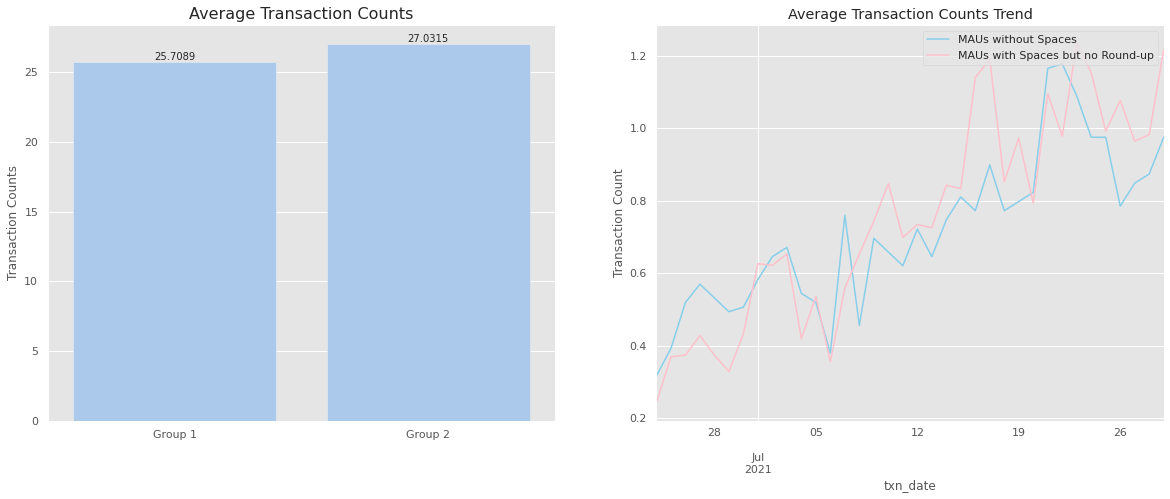

In [151]:
# plot total amount and trend of transaction counts
f = plt.subplots(figsize=(20, 16))

ax1 = plt.subplot(2, 2, 1)
sns.set_color_codes("pastel")
sns.barplot(
    x=["Group 1", "Group 2"],
    y=[
        rp_tx_group_1["txn_date"].agg("count") / 79,
        rp_tx_group_2["txn_date"].agg("count") / 222,
    ],
    ax=ax1,
    color="b",
)
ax1.bar_label(ax1.containers[0])
ax1.set_title("Average Transaction Counts", fontsize=16)
plt.ylabel("Transaction Counts")

g1 = rp_tx_group_1.groupby(["txn_date"]).agg("count")["txn_amount"] / 79
g2 = rp_tx_group_2.groupby(["txn_date"]).agg("count")["txn_amount"] / 222

ax2 = plt.subplot(2, 2, 2)
g1.plot(kind="line", label="MAUs without Spaces", color="skyblue", ax=ax2)
g2.plot(kind="line", label="MAUs with Spaces but no Round-up", color="pink", ax=ax2)
plt.ylabel("Transaction Count")
ax2.set_title("Average Transaction Counts Trend")
plt.legend(loc="upper right")

plt.show()

In [152]:
rp_tx_cnt_group_1 = rp_tx_group_1.groupby(["user_id"]).agg("sum")["txn_status"]
rp_tx_cnt_group_2 = rp_tx_group_2.groupby(["user_id"]).agg("sum")["txn_status"]

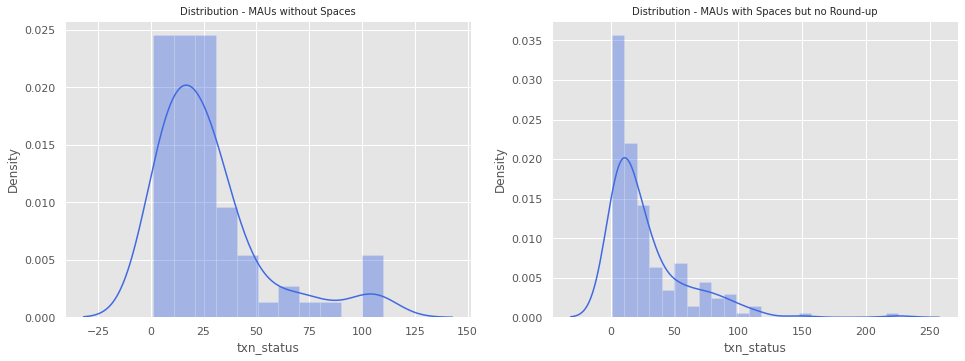

In [153]:
# check the distribution
fig = plt.subplots(figsize=(16, 12))

ax1 = plt.subplot(221)
sns.distplot(rp_tx_cnt_group_1, color="royalblue", ax=ax1)
ax1.set_title("Distribution - MAUs without Spaces", fontsize=10)

ax2 = plt.subplot(222)
sns.distplot(rp_tx_cnt_group_2, color="royalblue", ax=ax2)
ax2.set_title("Distribution - MAUs with Spaces but no Round-up", fontsize=10)

plt.show()

Hypothesis Test to analyse the mean of users transaction counts after receiving the notification, and enabled round_up
- Null hypothesis - average transaction counts for MAUs who has spaces <= MAUs who do not have spaces
- Alternative hypothesis - average transaction counts for MAUs who has spaces > MAUs who do not have spaces

In [154]:
# hypothesiscompare different for two testing groups
t_test, pval_oneside = stats.ttest_ind(
    rp_tx_cnt_group_2, rp_tx_cnt_group_1, alternative="greater"
)
alpha = 0.05
if pval_oneside < alpha:
    print(
        "Reject the null hypothesis, average transaction counts of MAUs who has spaces' is significantly more than MAUs who do not have spaces."
    )
else:
    print(
        "Fail to reject the null hypothesis, average transaction counts of MAUs who has spaces is not significantly more than MAUs who do not have spaces."
    )

Fail to reject the null hypothesis, average transaction counts of MAUs who has spaces is not significantly more than MAUs who do not have spaces.


For users who activated round-up, no matter which group they come from, the transaction counts per group is similar, but we can tell from the trend chart, users make more and more transactions after activating round-up. Since the overall comparison result shows no differences, there is no need to compare the control groups.

#### 3.4.1.3  What is the average transaction amount since they received the notifications

In [155]:
rp_tx_amt_group_1 = (
    rp_tx_group_1[["user_id", "txn_amount"]].groupby(["user_id"]).agg("mean")
)
rp_tx_amt_group_2 = (
    rp_tx_group_2[["user_id", "txn_amount"]].groupby(["user_id"]).agg("mean")
)

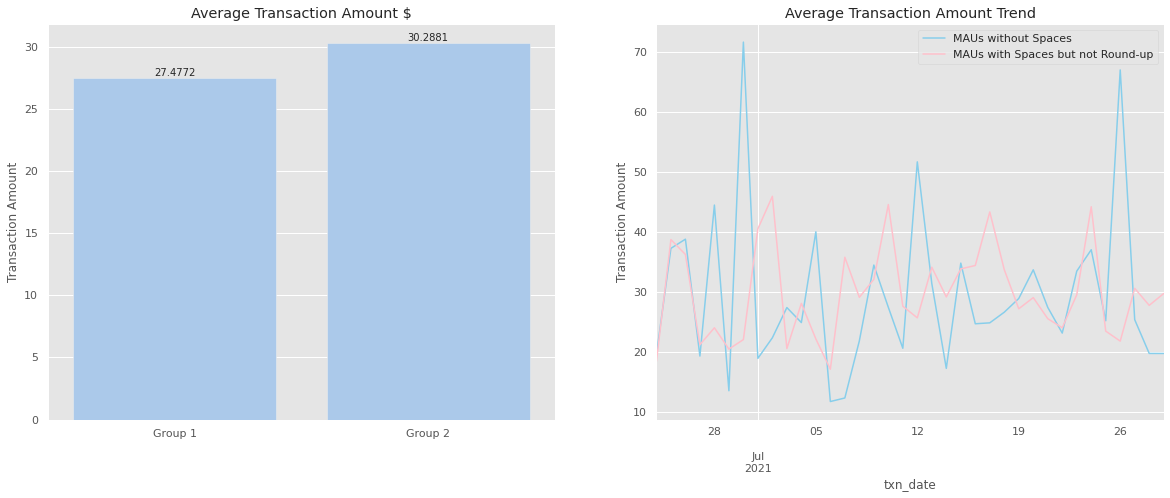

In [156]:
# plot total amount and trend of transaction counts
f = plt.subplots(figsize=(20, 16))

ax1 = plt.subplot(2, 2, 1)
sns.set_color_codes("pastel")
sns.barplot(
    x=["Group 1", "Group 2"],
    y=[
        rp_tx_amt_group_1.txn_amount.agg("sum") / 79,
        rp_tx_amt_group_2.txn_amount.agg("sum") / 222,
    ],
    ax=ax1,
    color="b",
)
ax1.bar_label(ax1.containers[0])
ax1.set_title("Average Transaction Amount $")
plt.ylabel("Transaction Amount")

g1 = rp_tx_group_1.groupby(["txn_date"]).agg("mean")["txn_amount"]
g2 = rp_tx_group_2.groupby(["txn_date"]).agg("mean")["txn_amount"]

ax2 = plt.subplot(2, 2, 2)
g1.plot(kind="line", label="MAUs without Spaces", color="skyblue", ax=ax2)
g2.plot(kind="line", label="MAUs with Spaces but not Round-up", color="pink", ax=ax2)
plt.ylabel("Transaction Amount")
ax2.set_title("Average Transaction Amount Trend")
plt.legend(loc="upper right")

plt.show()

### 3.4.2 In Group 1, which one performs better in terms of transactions after receiving the notification and activating round_up?

#### 3.4.2.1 How many transactions per user since they received the notifications

In [157]:
rp_txn_or_not_status = rp_txn_or_not["txn_status"]
rp_txn_or_not_groups = rp_txn_or_not["groups"]

In [158]:
size = pd.crosstab(rp_txn_or_not_groups, rp_txn_or_not_status)

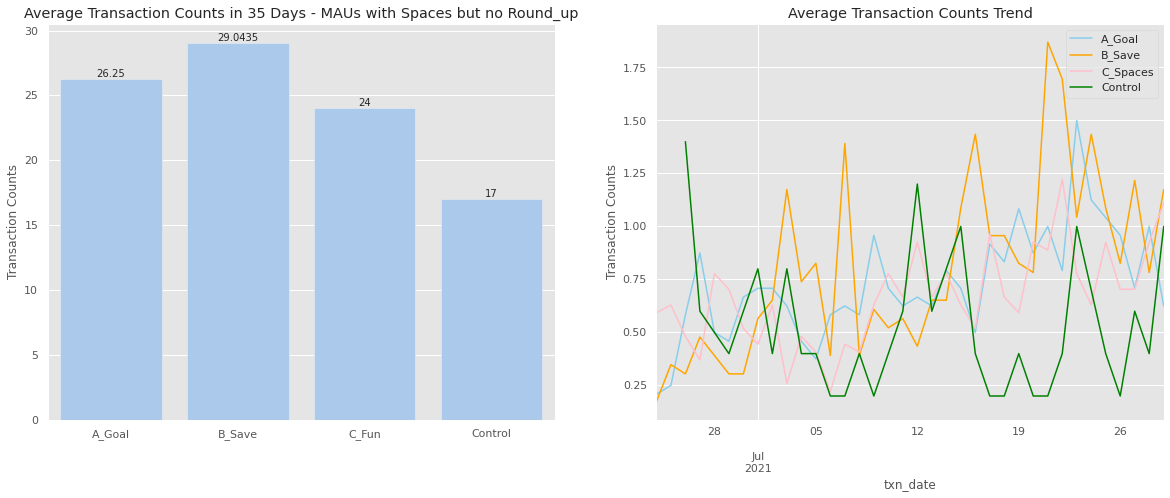

In [159]:
# plot total transaction counts

f = plt.subplots(figsize=(20, 16))

ax1 = plt.subplot(2, 2, 1)
sns.set_color_codes("pastel")
sns.barplot(
    x=["A_Goal", "B_Save", "C_Fun", "Control"],
    y=[
        rp_tx_group_1_treatment_a["txn_amount"].agg("count") / 24,
        rp_tx_group_1_treatment_b["txn_amount"].agg("count") / 23,
        rp_tx_group_1_treatment_c["txn_amount"].agg("count") / 27,
        rp_tx_group_1_control["txn_amount"].agg("count") / 5,
    ],
    ax=ax1,
    color="b",
)
ax1.bar_label(ax1.containers[0])
ax1.set_title(
    "Average Transaction Counts in 35 Days - MAUs with Spaces but no Round_up"
)
plt.ylabel("Transaction Counts")

g1 = rp_tx_group_1_treatment_a.groupby(["txn_date"]).agg("count")["txn_amount"] / 24
g2 = rp_tx_group_1_treatment_b.groupby(["txn_date"]).agg("count")["txn_amount"] / 23
g3 = rp_tx_group_1_treatment_c.groupby(["txn_date"]).agg("count")["txn_amount"] / 27
g4 = rp_tx_group_1_control.groupby(["txn_date"]).agg("count")["txn_amount"] / 5

ax2 = plt.subplot(2, 2, 2)
g1.plot(kind="line", label="A_Goal", color="skyblue", ax=ax2)
g2.plot(kind="line", label="B_Save", color="orange", ax=ax2)
g3.plot(kind="line", label="C_Spaces", color="pink", ax=ax2)
g4.plot(kind="line", label="Control", color="green", ax=ax2)
plt.ylabel("Transaction Counts")
ax2.set_title("Average Transaction Counts Trend")
plt.legend(loc="upper right")

plt.show()

In [160]:
rp_tx_cnt_group_1 = (
    rp_tx_group_1[["user_id", "groups", "txn_status"]]
    .groupby(["user_id", "groups"])
    .agg("sum")
    .reset_index()
)

In [161]:
anv_rp_tx_cnt_group_1 = (
    rp_tx_cnt_group_1[["groups", "txn_status"]].groupby(["groups"]).agg("mean")
)

Since all the users in this population made transactions, I directly move on to test if there are any statistical differences between the mean of the transaction counts. I use one-way-anova method to conduct the hypothesis test:
- Null hypothesis - average transaction counts for differenct treatment groups are the same
- Alternative hypothesis - average transaction counts for differenct treatment groups are different

Here are some prerequisites check:

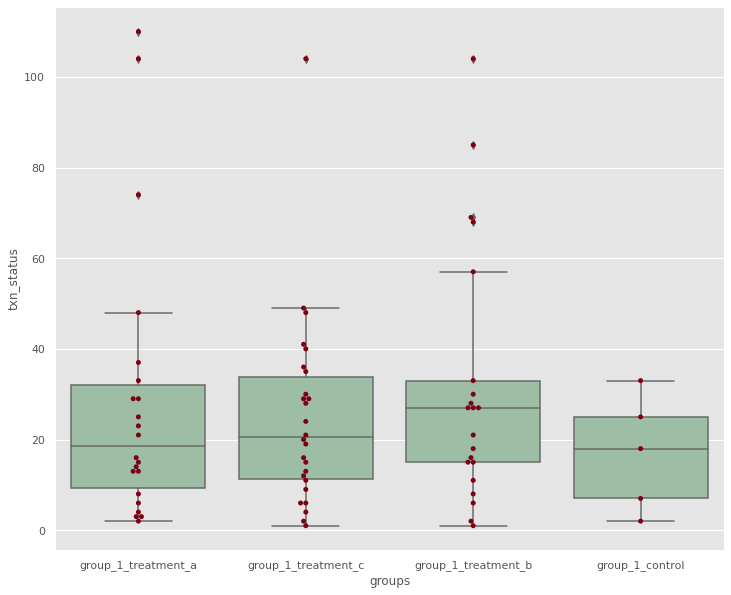

In [162]:
# using box plot to check the outliers
f = plt.subplots(figsize=(12, 10))
ax = sns.boxplot(x="groups", y="txn_status", data=rp_tx_cnt_group_1, color="#99c2a2")
ax = sns.swarmplot(x="groups", y="txn_status", data=rp_tx_cnt_group_1, color="#7d0013")
plt.show()

In [164]:
# Ordinary Least Squares (OLS) model
model = ols("txn_status ~ C(groups)", data=rp_tx_cnt_group_1).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(groups),1142.108626,3.0,0.558939,0.643894
Residual,47678.175158,70.0,NaN,NaN


P value here is much bigger than 0.05, fail to reject the null hypothesis, which means treatment groups do not affect the transaction counts.

#### 3.4.2.2 What is the average transaction amount since they received the notifications

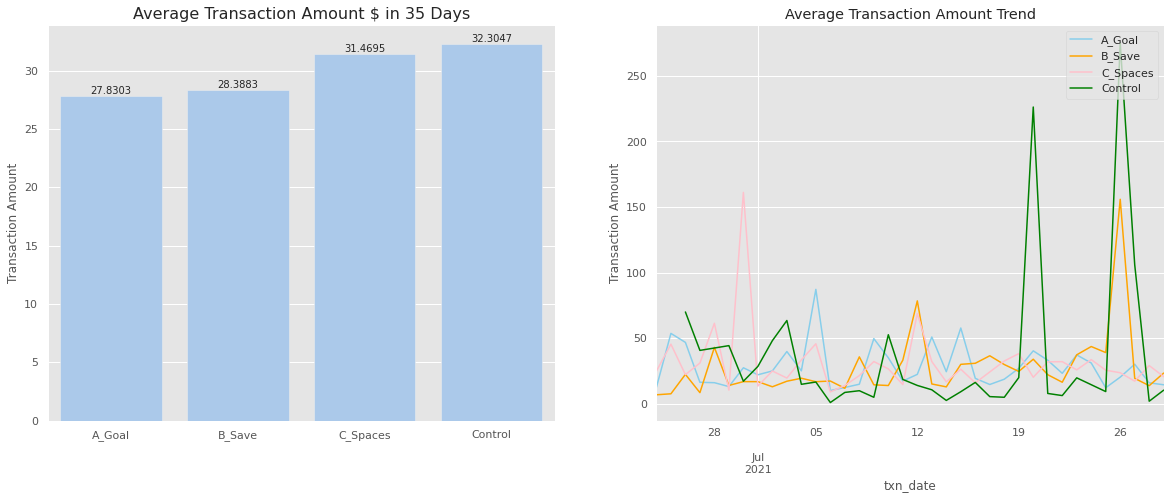

In [165]:
# plot total transaction counts

f = plt.subplots(figsize=(20, 16))

ax1 = plt.subplot(2, 2, 1)
sns.set_color_codes("pastel")
sns.barplot(
    x=["A_Goal", "B_Save", "C_Spaces", "Control"],
    y=[
        rp_tx_group_1_treatment_a["txn_amount"].agg("mean"),
        rp_tx_group_1_treatment_b["txn_amount"].agg("mean"),
        rp_tx_group_1_treatment_c["txn_amount"].agg("mean"),
        rp_tx_group_1_control["txn_amount"].agg("mean"),
    ],
    ax=ax1,
    color="b",
)
ax1.bar_label(ax1.containers[0])
ax1.set_title("Average Transaction Amount $ in 35 Days", fontsize=16)
plt.ylabel("Transaction Amount")

g1 = rp_tx_group_1_treatment_a.groupby(["txn_date"]).agg("mean")["txn_amount"]
g2 = rp_tx_group_1_treatment_b.groupby(["txn_date"]).agg("mean")["txn_amount"]
g3 = rp_tx_group_1_treatment_c.groupby(["txn_date"]).agg("mean")["txn_amount"]
g4 = rp_tx_group_1_control.groupby(["txn_date"]).agg("mean")["txn_amount"]

ax2 = plt.subplot(2, 2, 2)
g1.plot(kind="line", label="A_Goal", color="skyblue", ax=ax2)
g2.plot(kind="line", label="B_Save", color="orange", ax=ax2)
g3.plot(kind="line", label="C_Spaces", color="pink", ax=ax2)
g4.plot(kind="line", label="Control", color="green", ax=ax2)
plt.ylabel("Transaction Amount")
ax2.set_title("Average Transaction Amount Trend")
plt.legend(loc="upper right")

plt.show()

### 3.4.3 In Group 2, which one performs better in terms of transactions after receiving the notification and activating round_up?

#### 3.4.3.1 How many transactions per user since they received the notifications

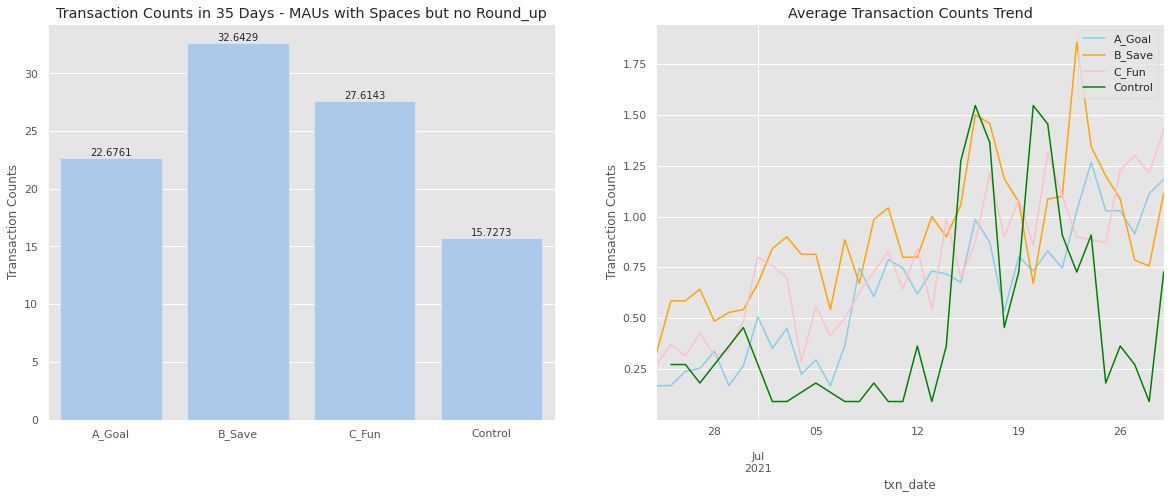

In [166]:
# plot total transaction counts
f = plt.subplots(figsize=(20, 16))

ax1 = plt.subplot(2, 2, 1)
sns.set_color_codes("pastel")
sns.barplot(
    x=["A_Goal", "B_Save", "C_Fun", "Control"],
    y=[
        rp_tx_group_2_treatment_a["txn_amount"].agg("count") / 71,
        rp_tx_group_2_treatment_b["txn_amount"].agg("count") / 70,
        rp_tx_group_2_treatment_c["txn_amount"].agg("count") / 70,
        rp_tx_group_2_control["txn_amount"].agg("count") / 11,
    ],
    ax=ax1,
    color="b",
)
ax1.bar_label(ax1.containers[0])
ax1.set_title("Transaction Counts in 35 Days - MAUs with Spaces but no Round_up")
plt.ylabel("Transaction Counts")

g1 = rp_tx_group_2_treatment_a.groupby(["txn_date"]).agg("count")["txn_amount"] / 71
g2 = rp_tx_group_2_treatment_b.groupby(["txn_date"]).agg("count")["txn_amount"] / 70
g3 = rp_tx_group_2_treatment_c.groupby(["txn_date"]).agg("count")["txn_amount"] / 70
g4 = rp_tx_group_2_control.groupby(["txn_date"]).agg("count")["txn_amount"] / 11

ax2 = plt.subplot(2, 2, 2)
g1.plot(kind="line", label="A_Goal", color="skyblue", ax=ax2)
g2.plot(kind="line", label="B_Save", color="orange", ax=ax2)
g3.plot(kind="line", label="C_Fun", color="pink", ax=ax2)
g4.plot(kind="line", label="Control", color="green", ax=ax2)
plt.ylabel("Transaction Counts")
ax2.set_title("Average Transaction Counts Trend")
plt.legend(loc="upper right")

plt.show()

In [167]:
rp_tx_cnt_group_2 = (
    rp_tx_group_2[["user_id", "groups", "txn_status"]]
    .groupby(["user_id", "groups"])
    .agg("sum")
    .reset_index()
)

In [168]:
anv_rp_tx_cnt_group_2 = (
    rp_tx_cnt_group_2[["groups", "txn_status"]].groupby(["groups"]).agg("mean")
)

Another ANOVA test
- Null hypothesis - average transaction counts for differenct treatment groups are the same
- Alternative hypothesis - average transaction counts for differenct treatment groups are different

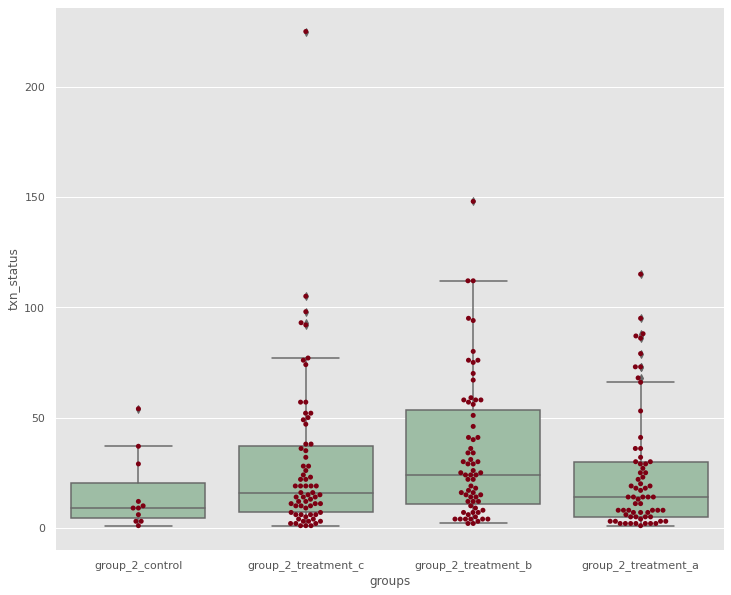

In [169]:
# using box plot to check the outliers
f = plt.subplots(figsize=(12, 10))
ax = sns.boxplot(x="groups", y="txn_status", data=rp_tx_cnt_group_2, color="#99c2a2")
ax = sns.swarmplot(x="groups", y="txn_status", data=rp_tx_cnt_group_2, color="#7d0013")
plt.show()

In [170]:
# Ordinary Least Squares (OLS) model
model = ols("txn_status ~ C(groups)", data=rp_tx_cnt_group_2).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(groups),4810.784553,3.0,1.630727,0.183374
Residual,202572.496399,206.0,NaN,NaN


In [171]:
# since my last version said there are difference in these samples, I am performing this tukey test to get more detailed view
from bioinfokit.analys import stat

# perform multiple pairwise comparison (Tukey's HSD)
# unequal sample size data, tukey_hsd uses Tukey-Kramer test
res = stat()
res.tukey_hsd(
    df=rp_tx_cnt_group_2,
    res_var="txn_status",
    xfac_var="groups",
    anova_model="txn_status ~ C(groups)",
)
res.tukey_summary
# Note: p-value 0.001 from tukey_hsd output should be interpreted as <=0.001

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,group_2_control,group_2_treatment_c,13.123474,-13.301421,39.548368,1.819255,0.564141
1,group_2_control,group_2_treatment_b,18.377205,-8.047690,44.802100,2.547559,0.275790
2,group_2_control,group_2_treatment_a,9.041958,-17.440207,35.524123,1.250740,0.789179
3,group_2_treatment_c,group_2_treatment_b,5.253731,-8.780134,19.287597,1.371351,0.741436
4,group_2_treatment_c,group_2_treatment_a,4.081515,-10.059891,18.222922,1.057272,0.865757
5,group_2_treatment_b,group_2_treatment_a,9.335247,-4.806159,23.476653,2.418195,0.321216


Based on both the ANOVA test and tukey test, all the treatment groups do not affect the transaction counts.

#### 3.4.3.2 What is the average transaction amount since they received the notifications

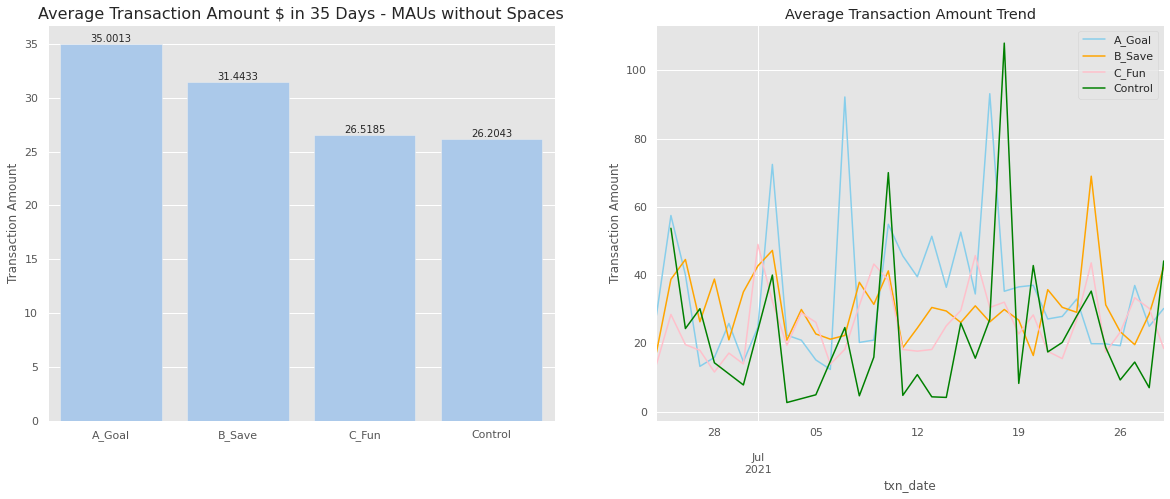

In [172]:
# plot total transaction counts

f = plt.subplots(figsize=(20, 16))

ax1 = plt.subplot(2, 2, 1)
sns.set_color_codes("pastel")
sns.barplot(
    x=["A_Goal", "B_Save", "C_Fun", "Control"],
    y=[
        rp_tx_group_2_treatment_a["txn_amount"].agg("mean"),
        rp_tx_group_2_treatment_b["txn_amount"].agg("mean"),
        rp_tx_group_2_treatment_c["txn_amount"].agg("mean"),
        rp_tx_group_2_control["txn_amount"].agg("mean"),
    ],
    ax=ax1,
    color="b",
)
ax1.bar_label(ax1.containers[0])
ax1.set_title(
    "Average Transaction Amount $ in 35 Days - MAUs without Spaces", fontsize=16
)
plt.ylabel("Transaction Amount")

g1 = rp_tx_group_2_treatment_a.groupby(["txn_date"]).agg("mean")["txn_amount"]
g2 = rp_tx_group_2_treatment_b.groupby(["txn_date"]).agg("mean")["txn_amount"]
g3 = rp_tx_group_2_treatment_c.groupby(["txn_date"]).agg("mean")["txn_amount"]
g4 = rp_tx_group_2_control.groupby(["txn_date"]).agg("mean")["txn_amount"]

ax2 = plt.subplot(2, 2, 2)
g1.plot(kind="line", label="A_Goal", color="skyblue", ax=ax2)
g2.plot(kind="line", label="B_Save", color="orange", ax=ax2)
g3.plot(kind="line", label="C_Fun", color="pink", ax=ax2)
g4.plot(kind="line", label="Control", color="green", ax=ax2)
plt.ylabel("Transaction Amount")
ax2.set_title("Average Transaction Amount Trend")
plt.legend(loc="upper right")

plt.show()

Roundup activation is a factor that affect transactions more compare to the notifications.

### 3.4 Multiplier Setup by Group

In [173]:
## import roundup multipliers
rpm = """
select date(r.created) date, user_id, case
when multiplier = 'ONE' then 1
when multiplier = 'TWO' then 2
when multiplier = 'THREE' then 3
when multiplier = 'FIVE' then 5
END multiplier
from etl_reporting.cn_automated_rule r
inner join etl_reporting.cn_round_up_transfer_action a
on a.rule_id = r.id
"""
rpm = df_from_sql("redshiftreader", rpm)

{"message": "started", "db": "redshiftreader", "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 126, "funcName": "df_from_sql", "created": "20210924T044650", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "d68a1247-43bb-40d3-b6d8-05993c8a3abf", "hostname": "172.18.0.4"}
{"message": "success", "db": "redshiftreader", "duration": 1.0924, "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 136, "funcName": "df_from_sql", "created": "20210924T044651", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "d68a1247-43bb-40d3-b6d8-05993c8a3abf", "hostname": "172.18.0.4"}


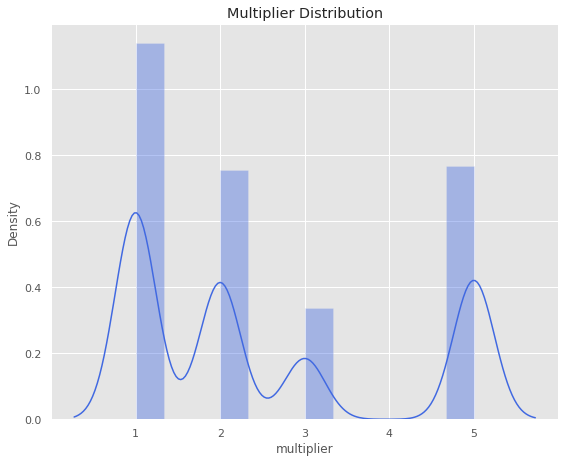

In [174]:
# plot the distribution
fig = plt.subplots(figsize=(20, 16))

ax = plt.subplot(221)
sns.distplot(rpm.multiplier, color="royalblue", ax=ax)
ax.set_title("Multiplier Distribution")

plt.show()

### 3.4.1 Compare Two Groups

In [175]:
# merge with samples
m_group_1_treatment_a = pd.merge(
    left=group_1_treatment_a, right=rpm, how="inner", on=["user_id"]
)
m_group_1_treatment_b = pd.merge(
    left=group_1_treatment_b, right=rpm, how="inner", on=["user_id"]
)
m_group_1_treatment_c = pd.merge(
    left=group_1_treatment_c, right=rpm, how="inner", on=["user_id"]
)
m_group_1_control = pd.merge(
    left=group_1_control, right=rpm, how="inner", on=["user_id"]
)
m_group_2_treatment_a = pd.merge(
    left=group_2_treatment_a, right=rpm, how="inner", on=["user_id"]
)
m_group_2_treatment_b = pd.merge(
    left=group_2_treatment_b, right=rpm, how="inner", on=["user_id"]
)
m_group_2_treatment_c = pd.merge(
    left=group_2_treatment_c, right=rpm, how="inner", on=["user_id"]
)
m_group_2_control = pd.merge(
    left=group_1_control, right=rpm, how="inner", on=["user_id"]
)

In [176]:
m_group_1 = pd.concat(
    [
        m_group_1_treatment_a,
        m_group_1_treatment_b,
        m_group_1_treatment_c,
        m_group_1_control,
    ]
)
m_group_2 = pd.concat(
    [
        m_group_2_treatment_a,
        m_group_2_treatment_b,
        m_group_2_treatment_c,
        m_group_2_control,
    ]
)

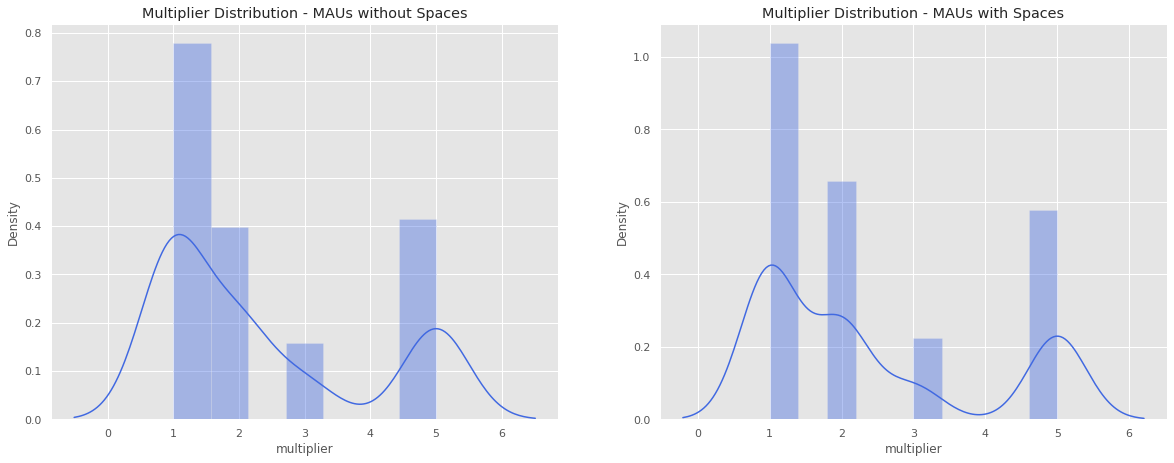

In [177]:
# plot the distribution
fig = plt.subplots(figsize=(20, 16))

ax1 = plt.subplot(221)
sns.distplot(m_group_1.multiplier, color="royalblue", ax=ax1)
ax1.set_title("Multiplier Distribution - MAUs without Spaces")

ax2 = plt.subplot(222)
sns.distplot(m_group_2.multiplier, color="royalblue", ax=ax2)
ax2.set_title("Multiplier Distribution - MAUs with Spaces")

plt.show()

Hypothesis Test 
- Null hypothesis - average multipliers for MAUs who has spaces <= MAUs who do not have spaces
- Alternative hypothesis - average multipliers for MAUs who has spaces > MAUs who do not have spaces

In [178]:
# st.mannwhitneyu(m_group_1.multiplier, m_group_2.multiplier, use_continuity=True, alternative='less')
st.kruskal(m_group_1_control.multiplier, m_group_2_control.multiplier)

KruskalResult(statistic=0.0, pvalue=1.0)

pvalue > 0.05, fail to reject the null hypothesis and group 2 does not have larger multiplier than group 1

Since the overall group 1 and group 2 do not have differences, we do not need to compare the control group anymore.

### 3.4.2 In Group 1, are median of each treatment groups and the control group the same?

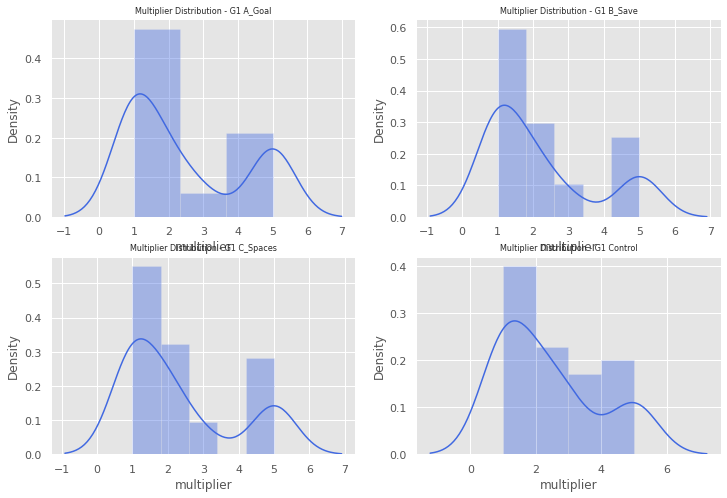

In [179]:
# plot the distribution
fig = plt.subplots(figsize=(12, 8))

ax1 = plt.subplot(221)
sns.distplot(m_group_1_treatment_a.multiplier, color="royalblue", ax=ax1)
ax1.set_title("Multiplier Distribution - G1 A_Goal", fontsize=8)
ax2 = plt.subplot(222)
sns.distplot(m_group_1_treatment_b.multiplier, color="royalblue", ax=ax2)
ax2.set_title("Multiplier Distribution - G1 B_Save", fontsize=8)
ax3 = plt.subplot(223)
sns.distplot(m_group_1_treatment_c.multiplier, color="royalblue", ax=ax3)
ax3.set_title("Multiplier Distribution - G1 C_Spaces", fontsize=8)
ax4 = plt.subplot(224)
sns.distplot(m_group_1_control.multiplier, color="royalblue", ax=ax4)
ax4.set_title("Multiplier Distribution - G1 Control", fontsize=8)

plt.show()

Hypothesis Test 
- Null hypothesis - in group 1, median of the multipliers for treatment are the same
- Alternative hypothesis - in group 1, median of the multipliers for treatment are the same

In [180]:
st.kruskal(
    m_group_1_treatment_a.multiplier,
    m_group_1_treatment_b.multiplier,
    m_group_1_treatment_c.multiplier,
    m_group_1_control.multiplier,
)

KruskalResult(statistic=1.0956007712316556, pvalue=0.7781361797594615)

pvalue > 0.05, fail to reject the null hypothesis, there are no significant differences between multipliers

### 3.4.3 In Group 2, are median of each treatment groups and the control group the same?

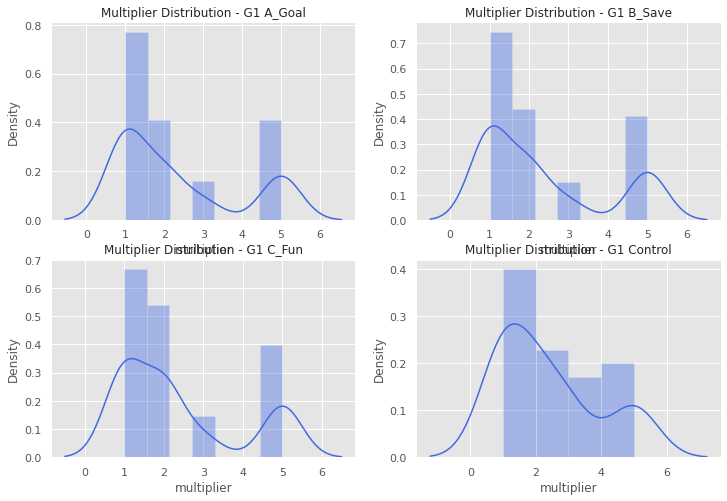

In [181]:
# plot the distribution
fig = plt.subplots(figsize=(12, 8))

ax1 = plt.subplot(221)
sns.distplot(m_group_2_treatment_a.multiplier, color="royalblue", ax=ax1)
ax1.set_title("Multiplier Distribution - G1 A_Goal", fontsize=12)
ax2 = plt.subplot(222)
sns.distplot(m_group_2_treatment_b.multiplier, color="royalblue", ax=ax2)
ax2.set_title("Multiplier Distribution - G1 B_Save", fontsize=12)
ax3 = plt.subplot(223)
sns.distplot(m_group_2_treatment_c.multiplier, color="royalblue", ax=ax3)
ax3.set_title("Multiplier Distribution - G1 C_Fun", fontsize=12)
ax4 = plt.subplot(224)
sns.distplot(m_group_2_control.multiplier, color="royalblue", ax=ax4)
ax4.set_title("Multiplier Distribution - G1 Control", fontsize=12)

plt.show()

Hypothesis Test 
- Null hypothesis - in group 2, median of the multipliers for treatment are the same
- Alternative hypothesis - in group 2, median of the multipliers for treatment are the same

In [182]:
st.kruskal(
    m_group_2_treatment_a.multiplier,
    m_group_2_treatment_b.multiplier,
    m_group_2_treatment_c.multiplier,
    m_group_2_control.multiplier,
)

KruskalResult(statistic=0.5501729089450536, pvalue=0.907738189460958)

pvalue > 0.05, fail to reject the null hypothesis, there are no significant differences between different treatment groups

## 4 Insights and Recommendations

- In terms of Roundup Activation, there are no significant organic activation rate differences among MAUs with Spaces and MAUs without Spaces, but when we include the treatment groups, there are significant differences between these two groups. Therefore, the treatment do affect the roundup activation and it performs better in Group 2- MAUs with spaces.
- In terms of transactions, MAUs with Spaces normally make more transactions than MAUs without Spaces, so we cannot conclude that the treatment overall has effect on increasing users' transaction counts. 
- For MAUs who do not have Spaces, the ‘Spaces’ focus message communicates better than others, and we can introduce Spaces to those users on a more frequent basis.
- For MAUs who have Spaces, there are no significant differences among treatment groups.
- MAUs with Spaces are more likely to try more new Spaces, MAUs with Spaces make more transactions than MAU without Spaces, though average transaction amounts are similar, MAUs with Spaces are more active users and spend more because they make more transactions
- Notifications have effect on MAUs who do not have spaces only for 7 days, while on MAUs with spaces, we can still see the differences in 14 days. Notifications have an instant or short-term impact on user behaviors especially when we capture the focus of our target audience. Therefore, we should communicate regularly with the target audiences based on their needs and wants so that they will have more exposure and knowledge of our products.
- Users who are using our product features have better retention than users who are not. In this case, while we are discovering more helpful products, we should also communicate efficiently to our users to fully introduce our current products, like Spaces, and let more users try our current features.